<p style="font-size: 40px; font-weight: bold; text-align: center;">HousePrice prediction project</p>

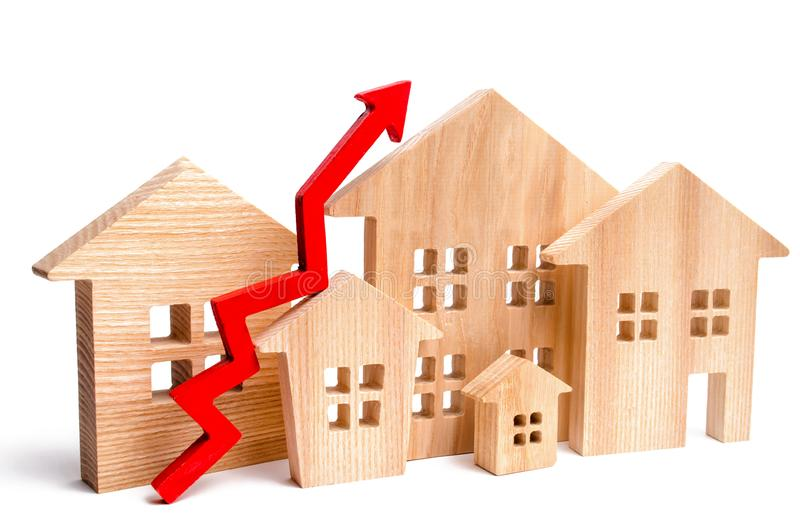

- <b>Main description:</b>
    - The project aimed at using statistical and machine learning algorithms to analyze and forecast the prices of houses. The project involves collecting data on housing prices and relevant features, such as location, size, age, and amenities, and training models to make predictions based on that data. The goal is to produce accurate predictions that can be used by real estate agents, developers, and buyers to make informed decisions.

## Import libraries

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Import model selection and evaluation functions
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)
from math import sqrt

# Import preprocessing libraries
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer

# Import feature engineering libraries
from feature_engine.discretisation import (
    EqualFrequencyDiscretiser, 
    EqualWidthDiscretiser
)
from feature_engine.selection import (
    SmartCorrelatedSelection, 
    DropConstantFeatures
)
from feature_engine.imputation import (
    ArbitraryNumberImputer, 
    EndTailImputer, 
    CategoricalImputer,
    MeanMedianImputer, 
    RandomSampleImputer
)
from feature_engine.encoding import (
    CountFrequencyEncoder, 
    OneHotEncoder, 
    OrdinalEncoder,
    RareLabelEncoder
) 

# Import machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Additional feature engineering libraries
from feature_engine.selection import (
    DropConstantFeatures, 
    DropDuplicateFeatures
)
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Others
from typing import Tuple

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Functions

In [75]:
def drop_useless_col(df:pd.DataFrame(), add_drop:list() = []) -> pd.DataFrame():
    '''
    This function takes in a pandas dataframe and a list of column
    names and drops the columns in the dataframe that have
    more than 45% missing values or are listed in add_drop.
    
    Parameters:
        df : DataFrame, containing the data
        add_drop : list, containing the additional column names to be dropped

    Return:
        df : DataFrame, modified dataframe after dropping the useless columns
    '''
    # Create a list of columns that have more than 45% missing values
    drop_list = [var for var in df.columns if df[var].isnull().mean()>0.45]
    drop_list += add_drop
    
    # Drop the columns in drop_list from the dataframe
    if add_drop == []:
        df = df.drop(columns = drop_list)
    else:
        df = df.drop(columns = drop_list + add_drop)
    
    # Print a message indicating which columns were dropped
    if drop_list != []:
        print('Dropped : ',drop_list)
        print('='*50)
    else:
        print('Nothing to drop!')
        
    # Return the modified dataframe
    return df

In [76]:
def missing_plot(df:pd.DataFrame(),dtype:str = 'all') -> None:
    '''
    This function takes a pandas dataset and a plotting parameter, 
    which can be "numeric", "categoric", or "all". It then plots 
    all the variables using matplotlib in the form of a graph 
    based on empty values.
    '''
    # Get a list of variables in the dataframe by dtype parameter
    if dtype == 'all':
        use_list = df.columns
    if dtype == 'categoric':
        use_list = list(df.select_dtypes(include = 'O'))
    if dtype == 'numeric':
        use_list = list(df.select_dtypes(exclude = 'O'))
        
    # Create a figure and set its size
    plt.figure(figsize = (8, 5))
    # Set the title of the plot
    plt.title('Percentage of missing values in {} columns'.format(dtype))
    # Calculate the percentage of missing values for each categorical variable
    # and store it in a dataframe sorted by the percentage of missing values
    missing_count = pd.DataFrame(df[[col for col in use_list if df[col].isnull().mean() > 0]].isnull().mean() * 100,
                                 columns = ['Percentage (%)']).sort_values(by = ['Percentage (%)'], 
                                                                 ascending = False).reset_index()
    # Rename the columns of the dataframe
    missing_count.columns = ['Features', 'Percentage (%)']
    # Create a barplot using the seaborn library
    sns.barplot(x = 'Percentage (%)', y = 'Features', data = missing_count, palette='Blues_r')
    plt.xticks(np.arange(0,110,10))
    plt.axvline(x=50, color='red', alpha = 0.6)
    plt.grid(axis='x')
    
    return None

In [77]:
def diagnostic_plots(df:pd.DataFrame(), variable:str) -> None:
    '''
    Diagnostic plots are graphical tools used to check 
    the assumptions of a statistical model and identify issues 
    such as outliers, non-linearity, etc. Examples include 
    scatter plots, residual plots and Q-Q plots.    
    '''
    # Create a figure
    fig, axes = plt.subplots(1, 3, figsize = (18, 5))

    # Create a histogram plot of the variable
    axes[0].hist(df[variable], bins = 30)
    # Set the y-axis label
    axes[0].set_ylabel('Number of houses')
    # Set the x-axis label
    axes[0].set_title("Histogram plot of variable")

    # Create a normal probability plot of the variable
    stats.probplot(df[variable], dist = 'norm', plot = axes[1])
    axes[1].set_title("Normal probability plot of variable")


    # Create a boxplot of the variable
    tmp_df = df[variable]
    tmp_df.name = None
    pd.DataFrame(tmp_df).boxplot(ax = axes[2])
    axes[2].set_title("Boxplot of variable")
    # Create suptitle
    fig.suptitle("Diagnostic plot '{}'".format(variable), fontsize=14, fontweight='bold')
    
    # Create grid
    axes[0].grid(which='major', axis='y')
    axes[1].grid(which='major', axis='y')
    
    return None

In [78]:
def correlation_filter(df:pd.DataFrame(), df_target:pd.DataFrame(), tolerance:float) -> list():  
    '''
    This function filters correlated variables from a given 
    dataset by taking in a dataframe 'df', a target dataframe 
    'df_target' and a tolerance level 'tolerance' as inputs, 
    creating a correlation matrix, iterating through the columns, 
    filtering out correlated variables that meet a certain criteria,
    creating a drop_list of these variables, and returning it.
    '''
    # create a correlation matrix using the input dataframe 'df' and target dataframe 'df_target'
    corr_matrix = pd.concat([df, df_target], axis = 1).corr()
    # create an empty list and dataframe to store filtered variables
    total_list = []
    total_df = pd.DataFrame()
    # iterate through the columns of the correlation matrix
    for i in list(corr_matrix.columns):
        # filter variables with a correlation coefficient less than the input tolerance and not equal to 1
        adding_df = corr_matrix[(abs(corr_matrix[i]) < tolerance) &
                                (corr_matrix[i]!= 1.0)][df_target.name]
        # if no variables meet the filtering criteria, skip
        if adding_df.empty:
            pass
        # otherwise, append the filtered variables to the total list
        else:
            total_list.append(adding_df)
    # create a temporary dataframe of the filtered variables and round the values to 2 decimal places
    temporary_df = pd.DataFrame(total_list).round(2)
    # create a list of the variables to be dropped by getting the last row of the temporary dataframe,
    # dropping any NaN values, and getting the index of the remaining variables
    drop_list = list(temporary_df.iloc[-1].dropna().index)
    # return the list of variables to be dropped
    return drop_list

In [79]:
def categorical_var_analyser(train:pd.DataFrame(),train_target:pd.Series(),var:str) -> None:
    '''
    This function displays the distribution of labels
    in categories and also shows the average price of 
    each label, colors the dominant and labels whose 
    mass is less than 5%.
    '''
    # Create a temporary DataFrame by concatenating the train and train_target DataFrames
    tmp_df = pd.concat([train,train_target],axis=1)

    # Count the number of occurrences of each value of the variable
    plot_count = tmp_df.groupby(var)[var].count().sort_values(ascending = False).to_dict()
    # Calculate the mean value of the target variable for each value of the variable
    plot_mean = tmp_df.groupby(var)[train_target.name].mean().sort_values(ascending = False).to_dict()
    
    # Set the threshold for determining which values to highlight
    axhline_count = len(train)*0.05
    axhline_mean = plot_mean[list(plot_count.keys())[0]]

    # Initialize dictionaries to store the color for each value of the variable
    my_color_count_dict = {}
    my_color_mean_dict = {}
    # Get the maximum count of occurrences of any value
    max_val = list(plot_count.values())[0]

    # Iterate through the unique values of the variable
    for i in list(X_train[var].value_counts().index):
        if i != 'nan':
            # If the value has a count greater than the threshold and is close to the max count, color it green
            if (plot_count[i] > axhline_count) and ((plot_count[i] > max_val-max_val*0.1) 
                                                    and (plot_count[i] < max_val+max_val*0.1)):
                my_color_count_dict[i] = 'limegreen'
            # If the value has a count greater than the threshold, color it light green
            elif (plot_count[i] > axhline_count):
                my_color_count_dict[i] = 'lightgreen'
            # If the value has a count less than the threshold, color it light grey
            else:
                my_color_count_dict[i] = 'lightgrey'

    # Iterate through the unique values of the variable
    for i in plot_mean:
        if my_color_count_dict[i] == 'limegreen':
            my_color_mean_dict[i] = 'limegreen'
        elif my_color_count_dict[i] == 'lightgreen':
            my_color_mean_dict[i] = 'lightgreen'
        else:
            my_color_mean_dict[i] = 'lightgrey'
            
    # Print the variable name for reference
    print('--------------------')
    print(var)
    # Create a figure with 2 subplots
    plt.figure(figsize=(16,4))
    
    # First subplot shows the count of each value of the variable
    plt.subplot(1,2,1)
    pd.Series(plot_count).plot.bar(color = my_color_count_dict.values())
    plt.title('String counter')
    # Add a red line at the threshold for count
    red_line = plt.axhline(y = axhline_count,color = 'r',alpha = 0.8)
    plt.grid(axis='y')
    plt.legend([red_line],['Under 5%'])
    
    # Second subplot shows the mean value of the target variable for each value of the variable
    plt.subplot(1,2,2)
    pd.Series(plot_mean).plot.bar(color = my_color_mean_dict.values())
    plt.title('Mean price by each label')
    red_line = plt.axhline(y = axhline_mean,color = 'r',alpha = 0.8)
    plt.grid(axis='y')
    plt.legend([red_line],['Dominant label mean price'])

    print('--------------------')
    plt.show()
    
    return None

In [80]:
def dominant_cat_analyser(
    train:pd.DataFrame(),
    train_target:pd.Series(), 
    searching_type:str = 'hard',
    plot:str = 'yes'
) -> list():  
    '''
    This function identifies categorical
    variables in which there is a dominant label.
    '''
    # Initialize an empty list to store the dominant categorical columns
    dominant_cat_list = []
    # Create an empty dataframe to store the relative frequencies of unique values in each column
    test = pd.DataFrame()
    # Get the relative frequencies of unique values in each column
    tmp_df = show_unique_labels(train)
    # Iterate over the categorical columns
    for i in categorical_numerical_splitter(train)[0]: 
        # Add the relative frequencies of unique values to the test dataframe
        test[i] = tmp_df[i+'_mean']
        # Check the searching_type input is valid
        if searching_type not in ['hard', 'light']:
            raise ValueError("Invalid searching_type input, it should be either 'hard' or 'light'")
        # Check if the column is a dominant category
        if searching_type == 'hard':
            if test[i][0] > 0.8:
                dominant_cat_list.append(i)
        elif searching_type == 'light':
            if (test[i][:2].sum() > 0.8) and (test[i][0] < 0.5):
                dominant_cat_list.append(i)
    # check if the plot input is valid
    if plot not in ['yes', 'no']:
        raise ValueError("Invalid plot input, it should be either 'yes' or 'no'")
    # Plot the dominant categories if plot input is 'yes'
    if plot == 'yes':
        for var in dominant_cat_list:
            categorical_var_analyser(train,train_target,var)
    # Return the list of dominant categories
    return dominant_cat_list

In [81]:
def categorical_numerical_splitter(df:pd.DataFrame()) -> Tuple[list,list]:
    '''
    This function separates variables 
    into numerical and categorical columns.
    
    Parameters:
        df : DataFrame, containing the data
        
    Return:
        cat: list, containing categorical column names.
        num: list, containing numerical column names.
    '''
    # Select the columns with dtype 'object' and convert them to a list
    cat = df.select_dtypes(include='object').columns.tolist()
    # Select all columns except the ones with dtype 'object' and convert them to a list
    num = df.select_dtypes(exclude='object').columns.tolist()
    # Return the lists of categorical and numerical column names
    return cat, num

In [82]:
def show_unique_labels(df:pd.DataFrame()) -> pd.DataFrame() -> pd.DataFrame():
    '''
    This function sorts variables by the number of 
    labels and displays their distribution 
    relative to all rows in the column.
    
    Parameters:
        df : DataFrame, containing the data
    
    Return:
        unique_labels : DataFrame, containing unique labels and relative frequencies
    '''
    # Get the column names of categorical columns from the function `categorical_numerical_splitter`
    categorical_cols = categorical_numerical_splitter(df)[0]
    # Create a dictionary with column names as keys and number of unique values as values
    len_dict = {col: len(df[col].unique()) for col in categorical_cols}
    # Sort the column names based on the number of unique values in descending order
    sorted_cols = sorted(len_dict, key=len_dict.get, reverse=True)
    # Create an empty dataframe to store the unique labels and relative frequencies
    unique_labels = pd.DataFrame()
    # Iterate over the sorted column names
    for col in sorted_cols:
        # Add the unique labels as a column in the dataframe
        unique_labels[col] = pd.DataFrame(df[col].value_counts().index)
        # Add the relative frequencies of the unique labels as a column in the dataframe
        unique_labels[col+'_mean'] = pd.Series((df[col].value_counts()/len(df[col])).values)
    # Return the dataframe
    return unique_labels

In [83]:
def plot_categories(df:pd.DataFrame(),target:pd.DataFrame(), var:str) -> None:
    '''
    This function displays the distribution 
    of labels and their average cost.
    '''
    # Concatenate df and target dataframe
    tmp_df = pd.concat([df, target], axis=1)
    # Plot the percentage of each category in var
    df[var].value_counts(normalize=True).mul(100).sort_values(ascending=False).plot.bar(color='steelblue')
    plt.ylabel('Percentage (%)')
    # Create a twin axis for the mean value of target
    ax2 = plt.twinx()
    tmp_df.groupby(var)[target.name].mean().sort_values(ascending=False).plot(color='b', marker='o')
    plt.ylabel('Mean price')
    # Add a horizontal line at 5
    plt.axhline(y=5, color="red", alpha=0.6)
    # Add grid on y axis
    plt.grid(axis='y')
    # Set plot title
    plt.title(var)
    
    return None

## Loading dataset

In [84]:
# Exploring space in visual columns
pd.set_option('display.max_columns',None)

# Data import
data = pd.read_csv('houseprice.csv')

## Exploratory data analysis

In [85]:
'''
First of all define lists with 
categorical, numerical, datetime 
and discrete variables.
'''
# Defining lists to store categorical, numerical, datetime and discrete variables
categorical_vars = [var for var in data.columns if data[var].dtype == 'O']
numeric_vars = [var for var in data.columns if data[var].dtypes != "O" and var != 'SalePrice']
year_vars = [var for var in numeric_vars if 'Yr' in var or 'Year' in var]
discrete = [var for var in data.columns if data[var].dtype != 'O' and var != 'SalePrice' and data[var].nunique()<20 and var not in year_vars]

# Reassign numerical_vars by extracting ['ID'], discrete and datetime variables
numeric_vars = [var for var in numeric_vars if var not in discrete and var not in ['Id', 'SalePrice'] and var not in year_vars]
print('Total number of categorical vars is : ' , len(categorical_vars))
print('Total number of numerical vars is : ' ,len(numeric_vars))
print('Total number of discrete vars is : ', len(discrete))
print('Year vars list : ',year_vars)

Total number of categorical vars is :  43
Total number of numerical vars is :  18
Total number of discrete vars is :  14
Year vars list :  ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']


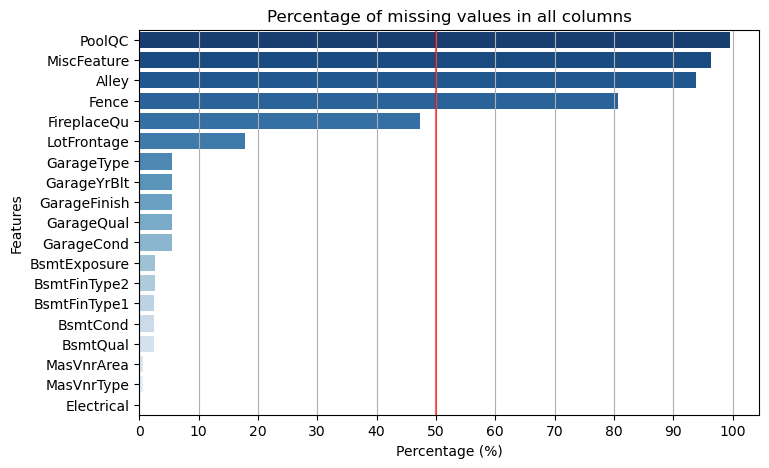

In [86]:
# Observing all variables contain null values.
missing_plot(data,dtype='all')

- <b>Conclusion</b>
    - This plot displays variables that contain empty values. The red line represents a threshold of 50%.<br> These variables will be dropped in the following process.

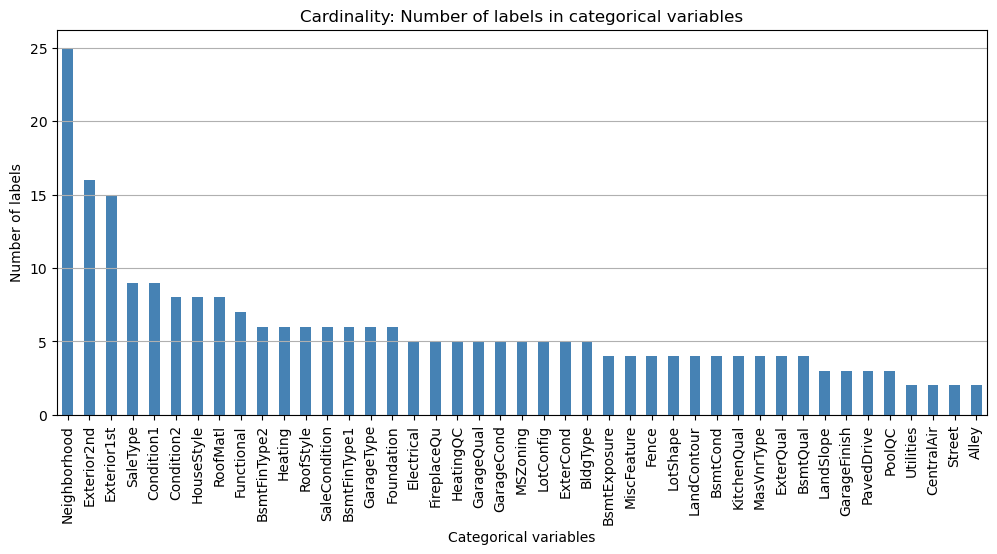

In [87]:
# Observing the quantity of labels in categorical variables.
data[categorical_vars].nunique().sort_values(ascending = False).plot.bar(figsize = (12, 5), color = 'steelblue')
plt.title('Cardinality: Number of labels in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of labels')
plt.grid(axis='y')
plt.show()

- <b>Conclusion</b>
    - There are three categorical columns with high cardinality (Neighborhood, Exterior2nd, and Exterior1st)<br> which have more than 10 labels each. Specifically, Neighborhood has 25 labels, Exterior2nd has 16 labels, and Exterior1st has 15 labels.

In [88]:
# Splitting dataset on train and test
X_train,X_test,y_train,y_test = train_test_split(
    data.drop(columns=['SalePrice', 'Id'], axis=1),
    data.SalePrice,
    test_size=0.3,
    random_state=0
)
print("Training data set dimension : {}".format(X_train.shape))
print("Testing data set dimension : {}".format(X_test.shape))

Training data set dimension : (1022, 79)
Testing data set dimension : (438, 79)


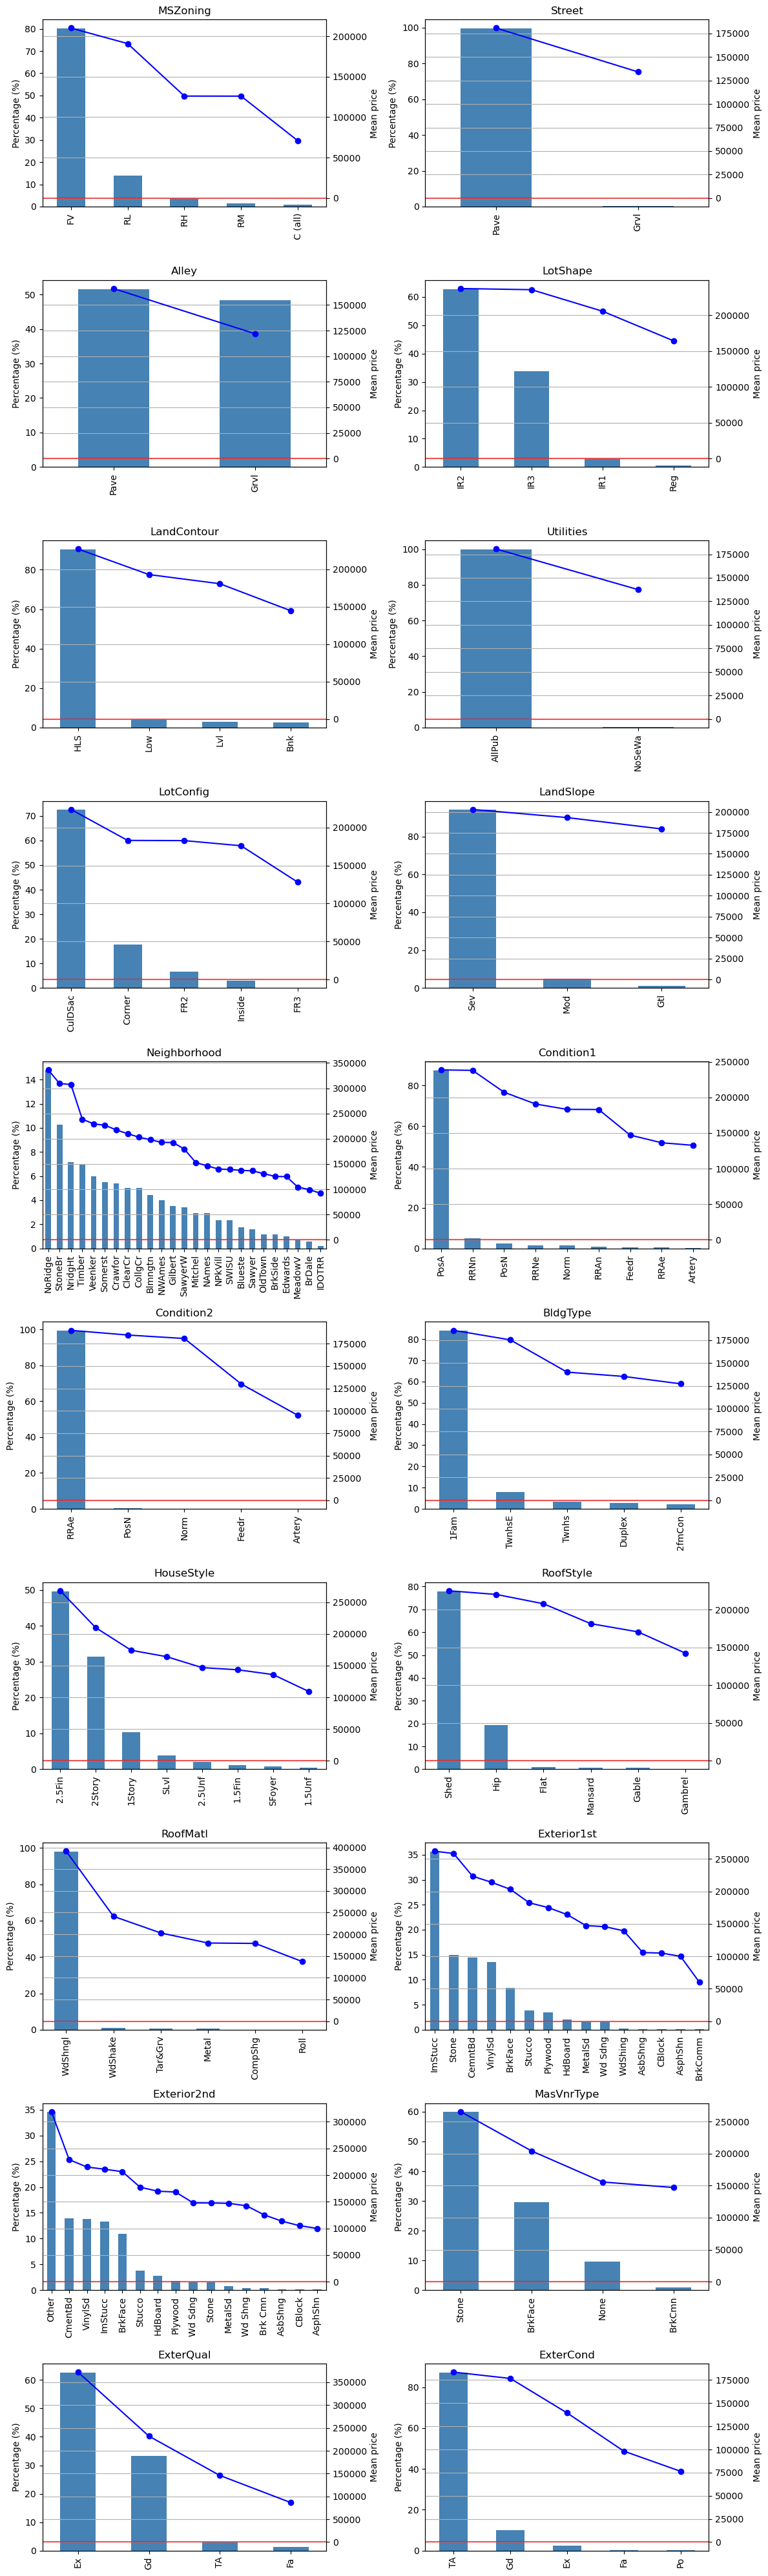

In [89]:
# Observating cardinality & mean price by each label
fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(12, 40))
i = 1
for col in categorical_vars[:20]:
    plt.subplot(10, 2, i)
    plot_categories(X_train,y_train,col)
    i += 1
plt.tight_layout()
plt.show()

- <b>Conclusion</b>
    - This plot shows the number of labels each column has, the average price associated with each<br> label, and enables us to recognize the most common labels.

## Distribution and Outliers

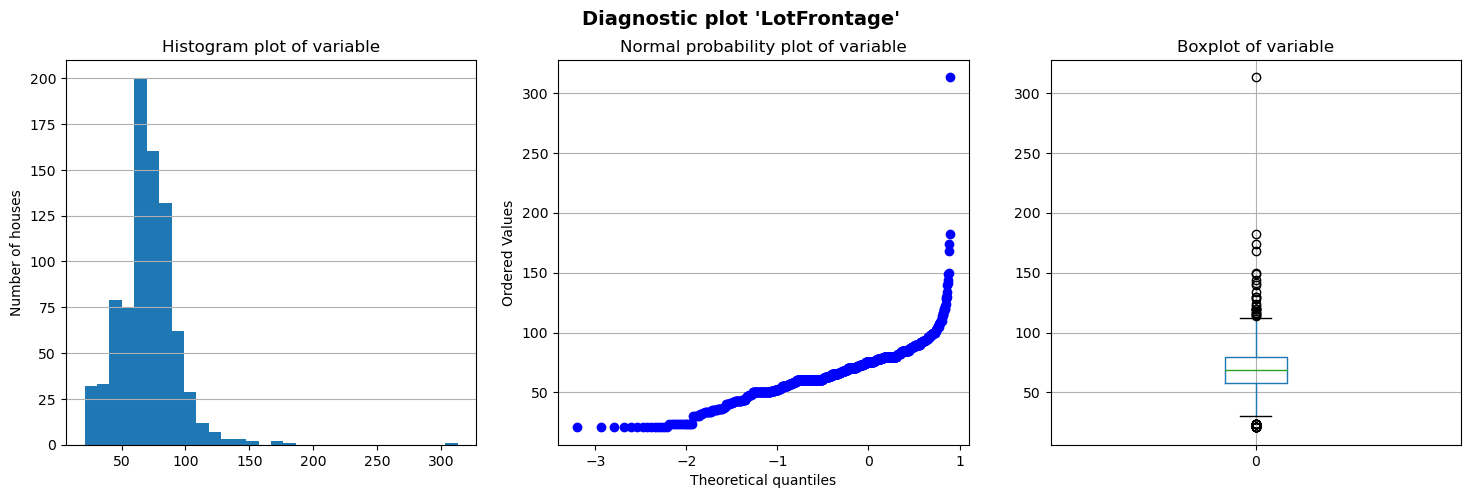

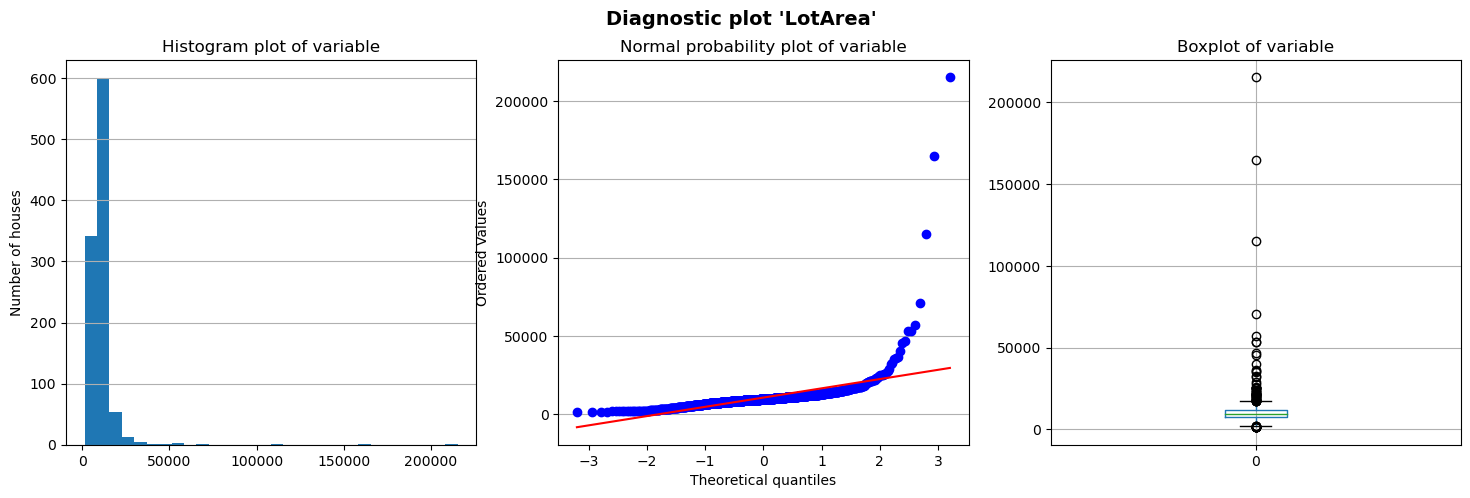

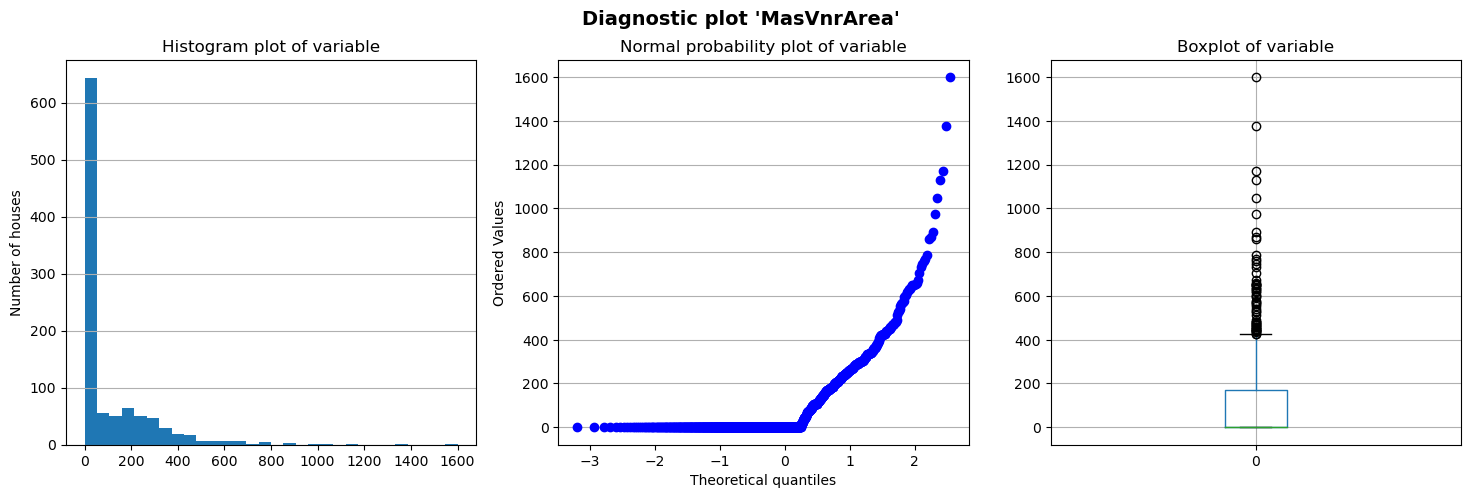

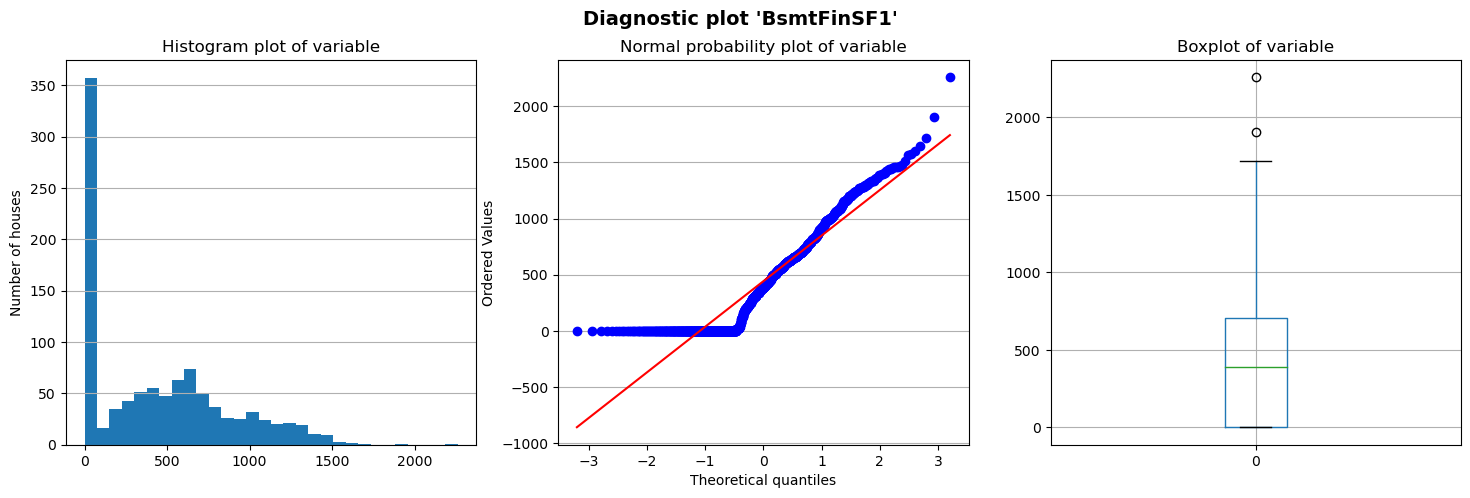

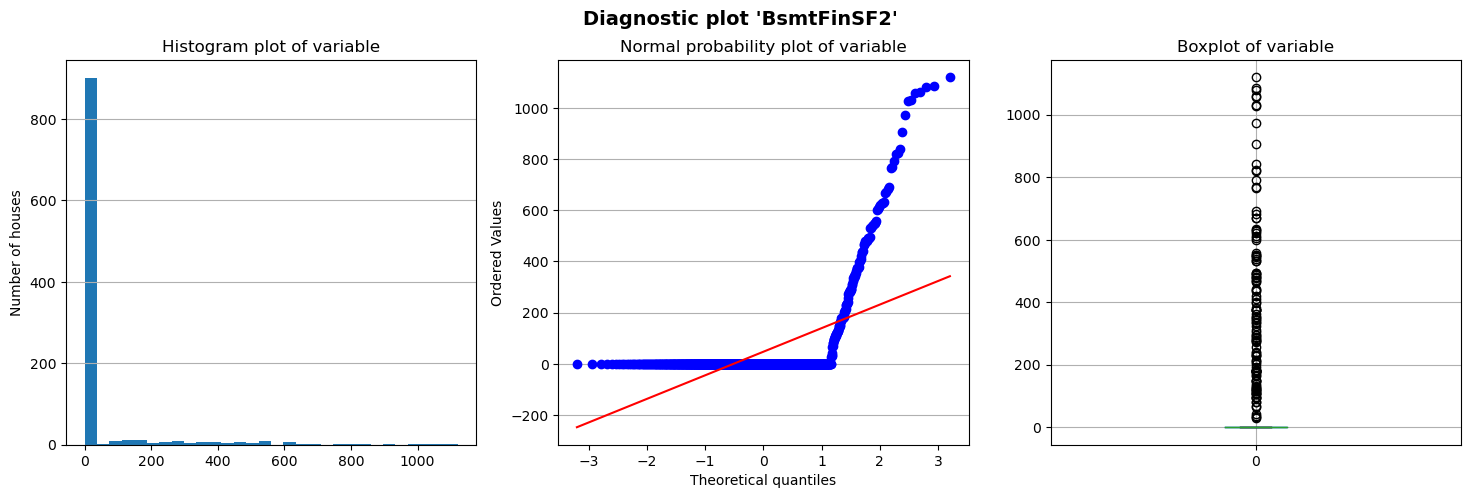

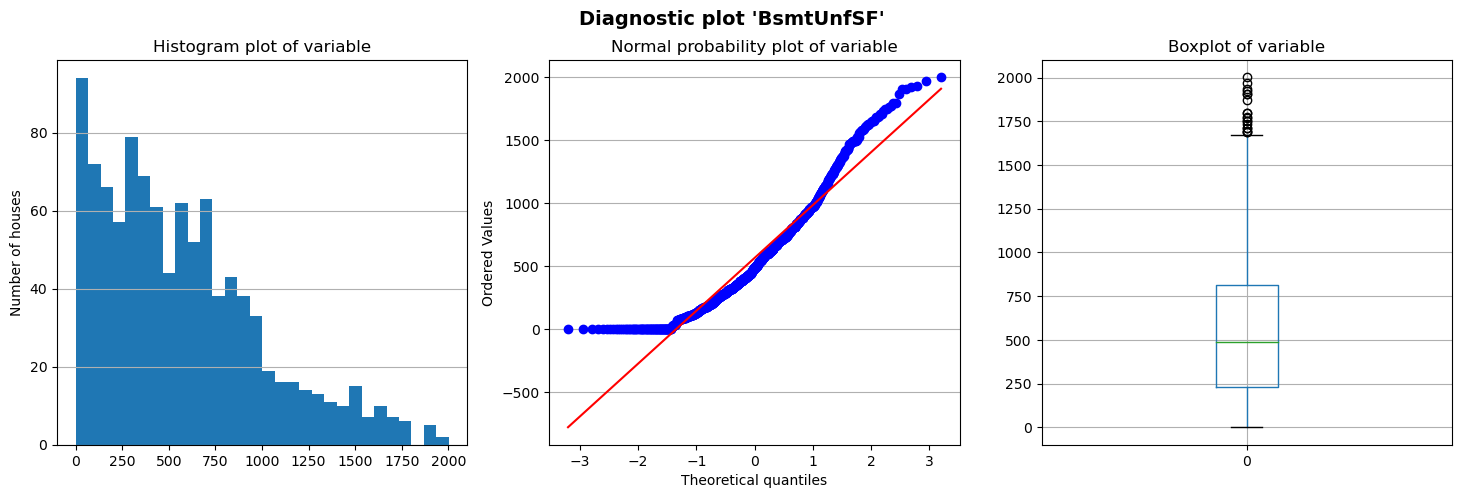

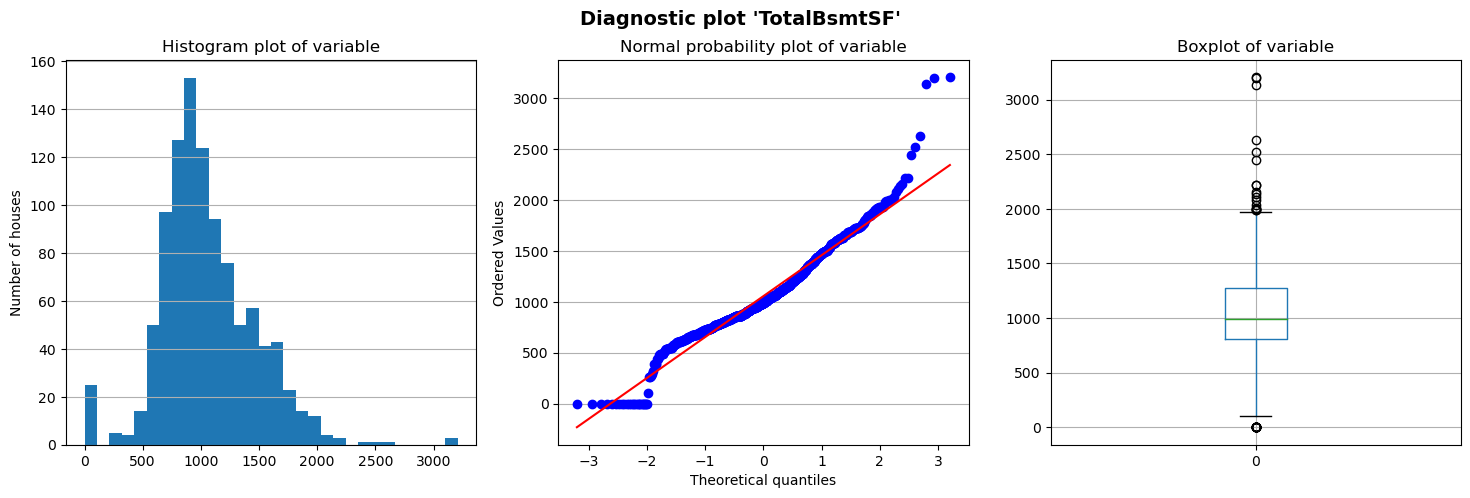

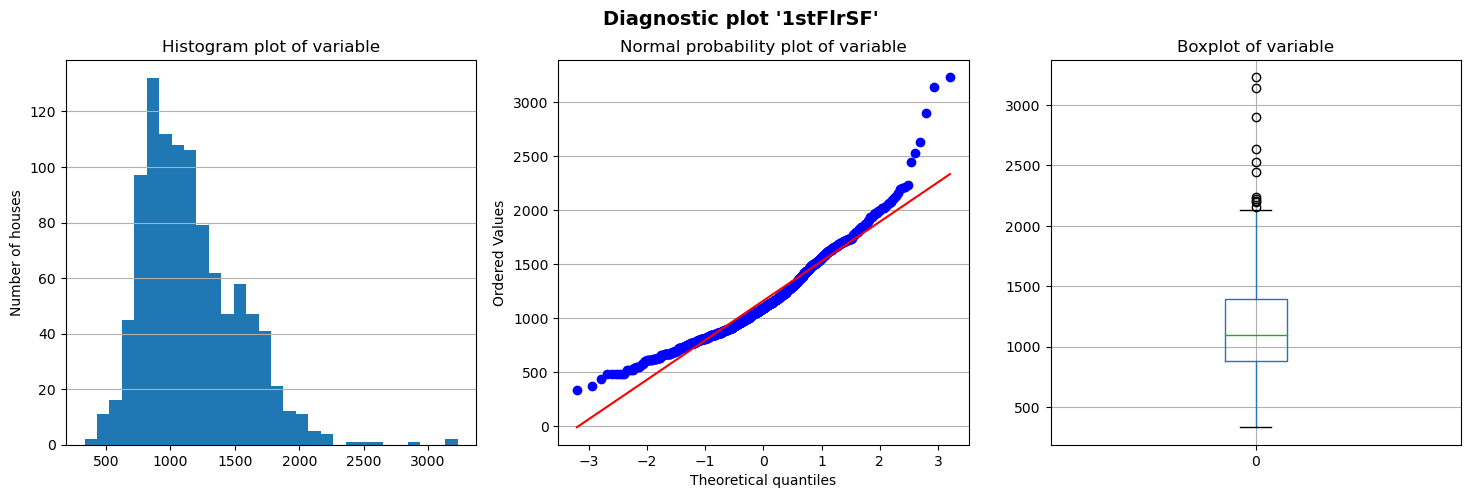

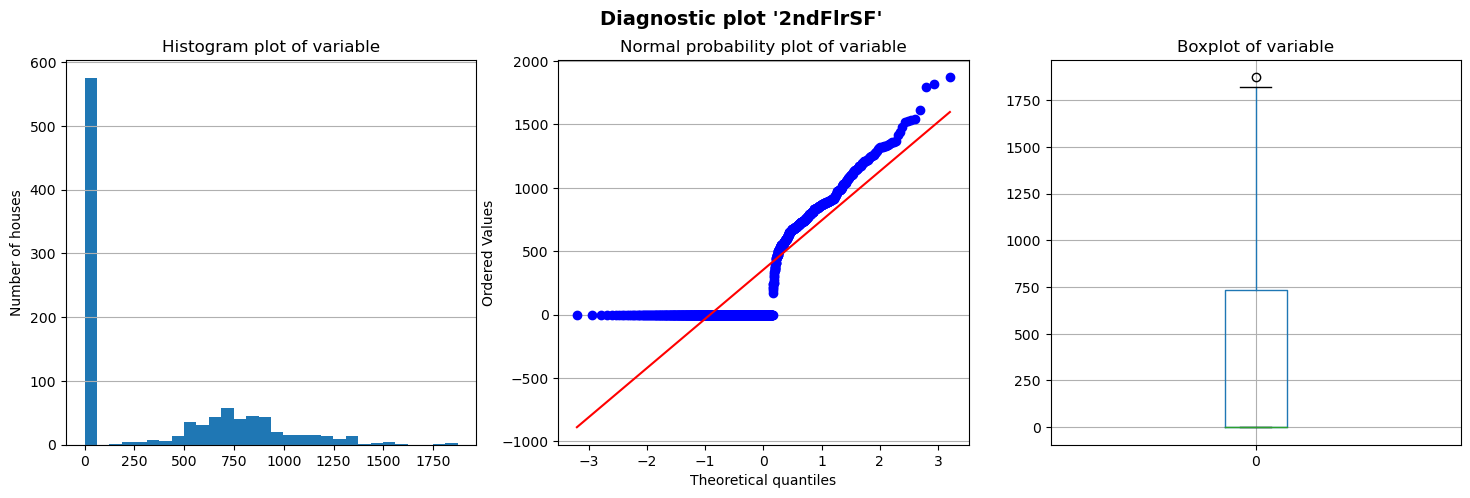

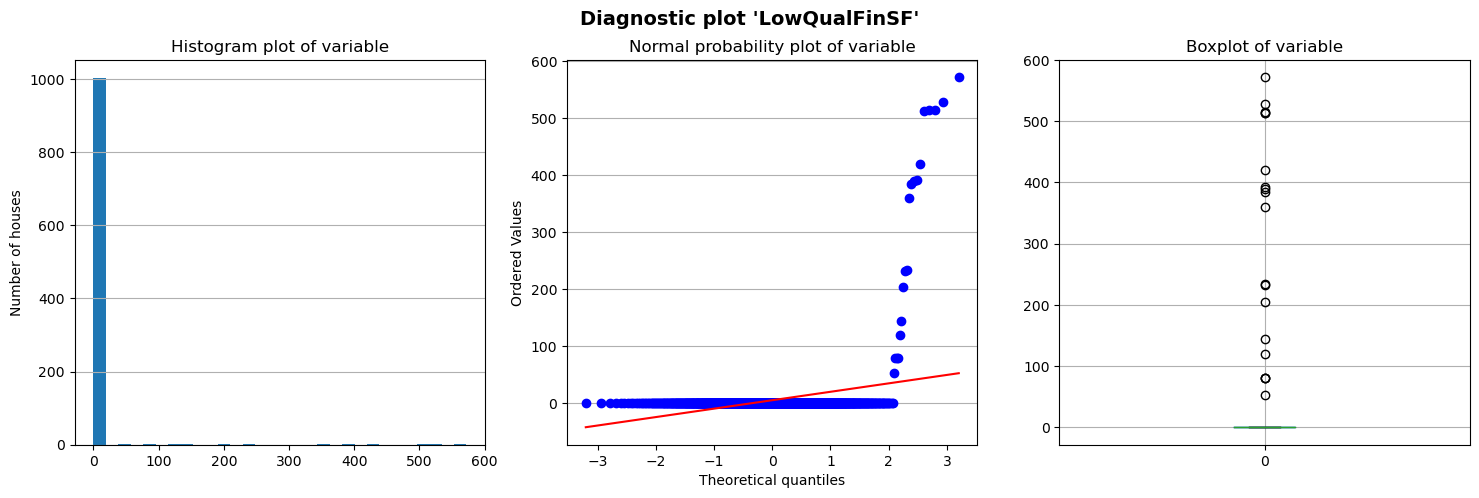

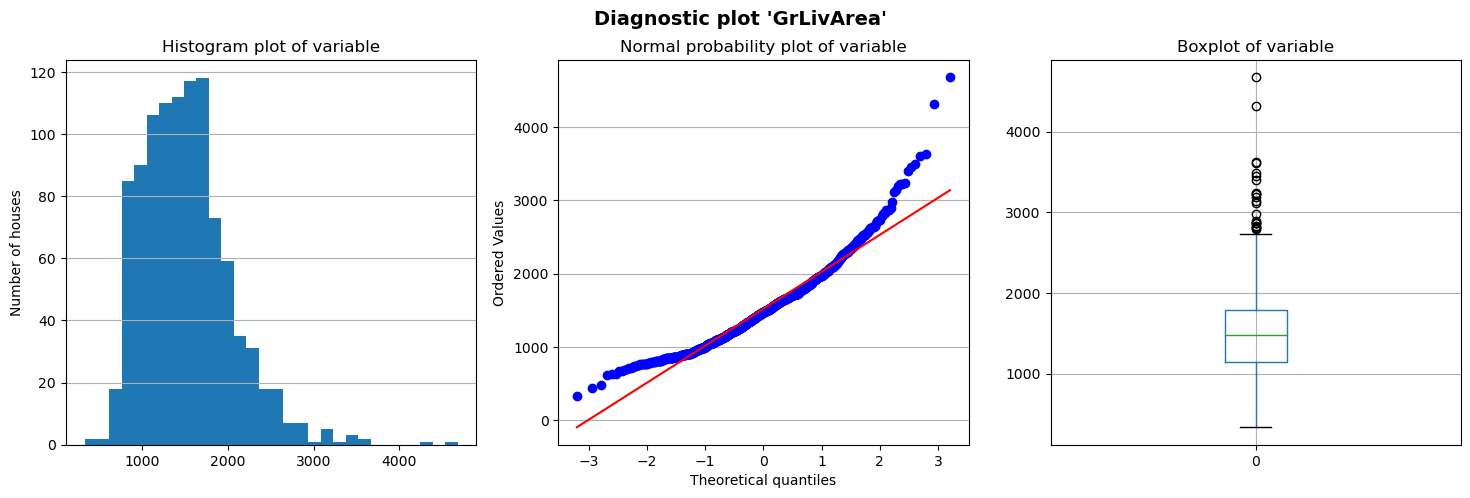

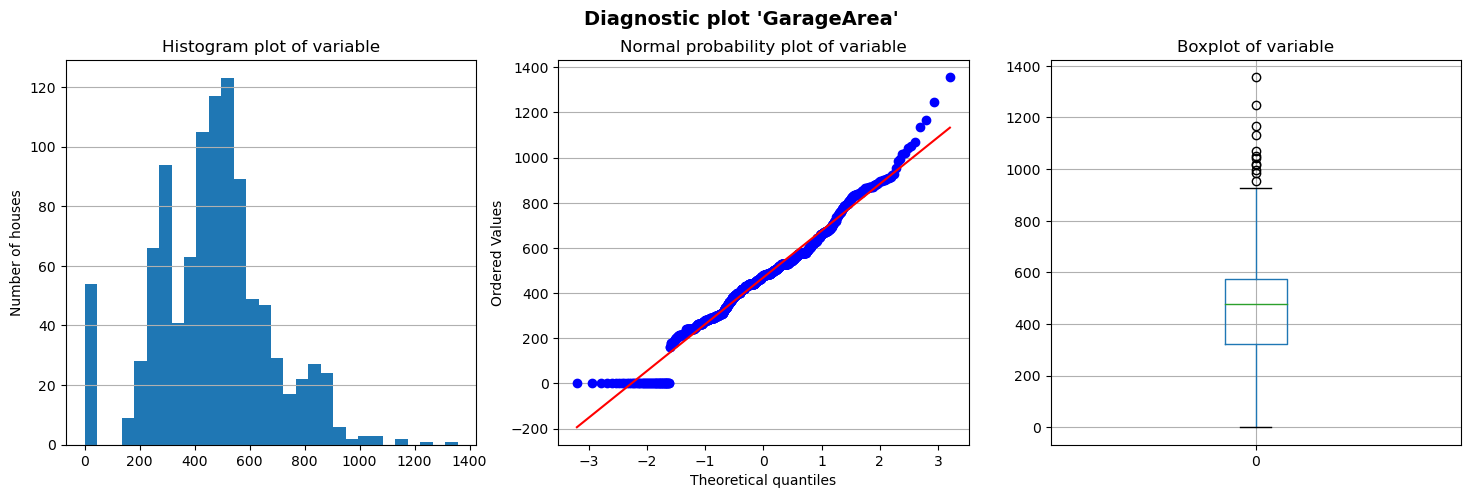

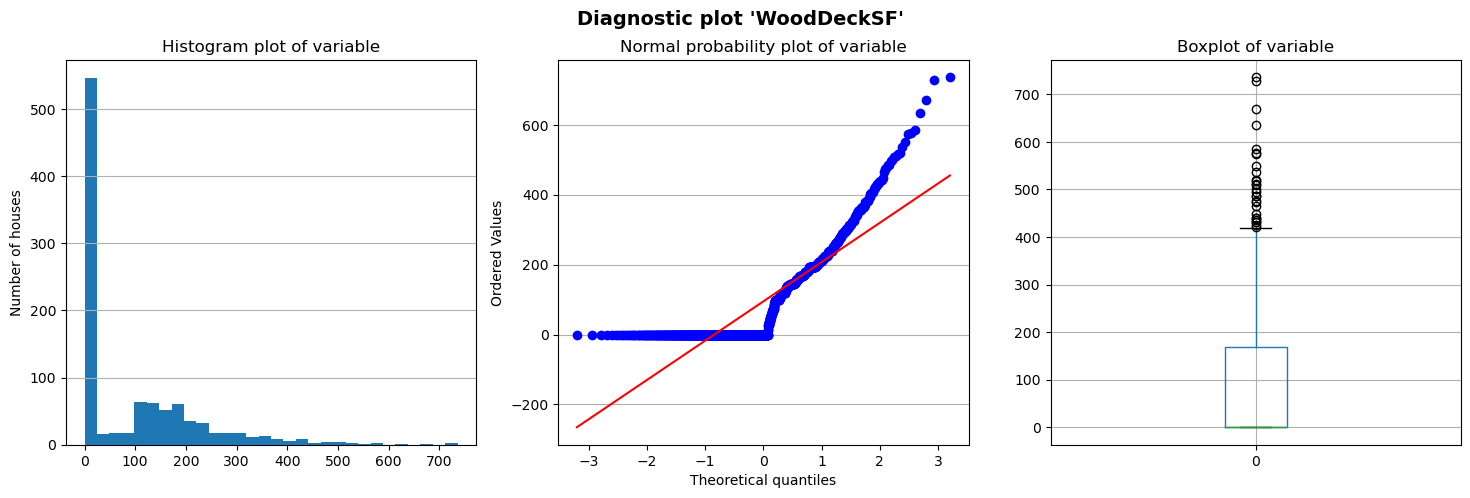

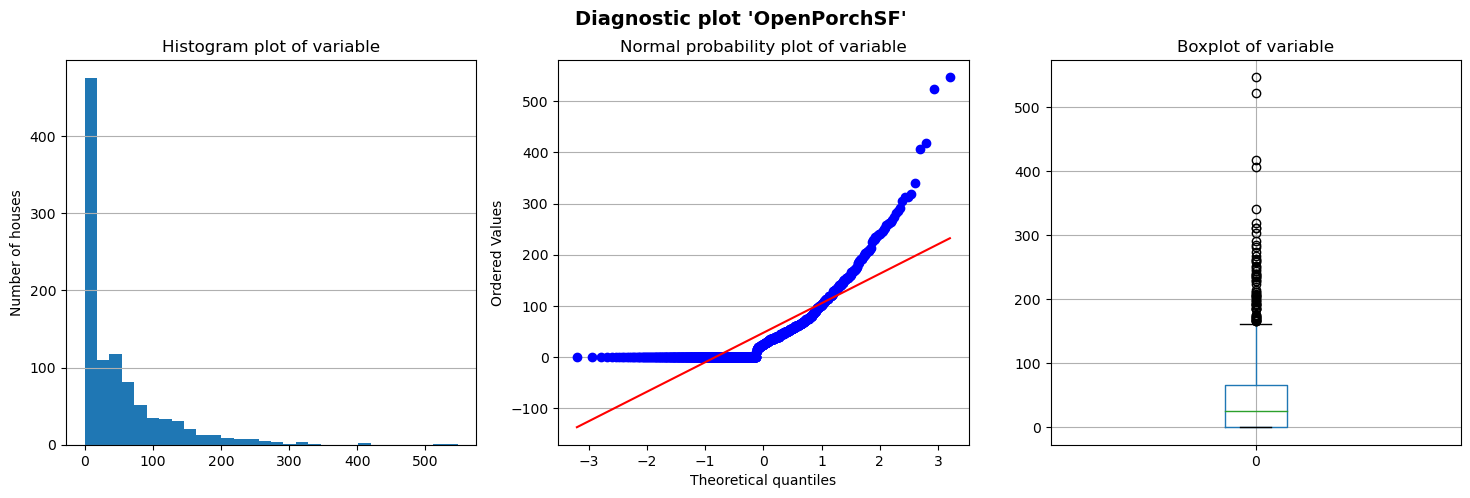

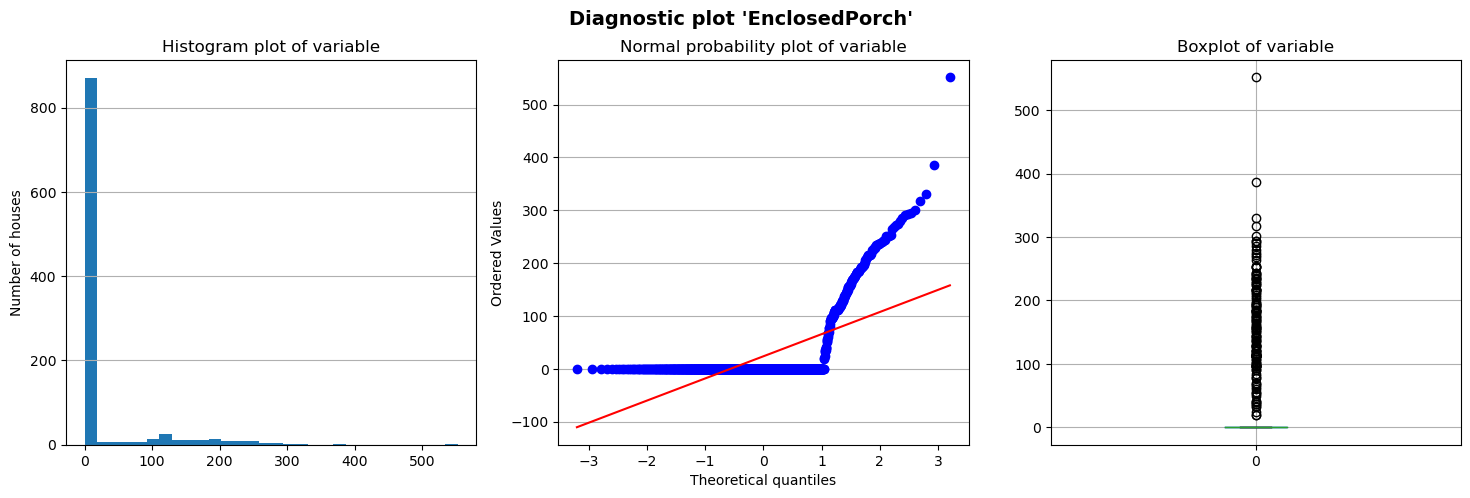

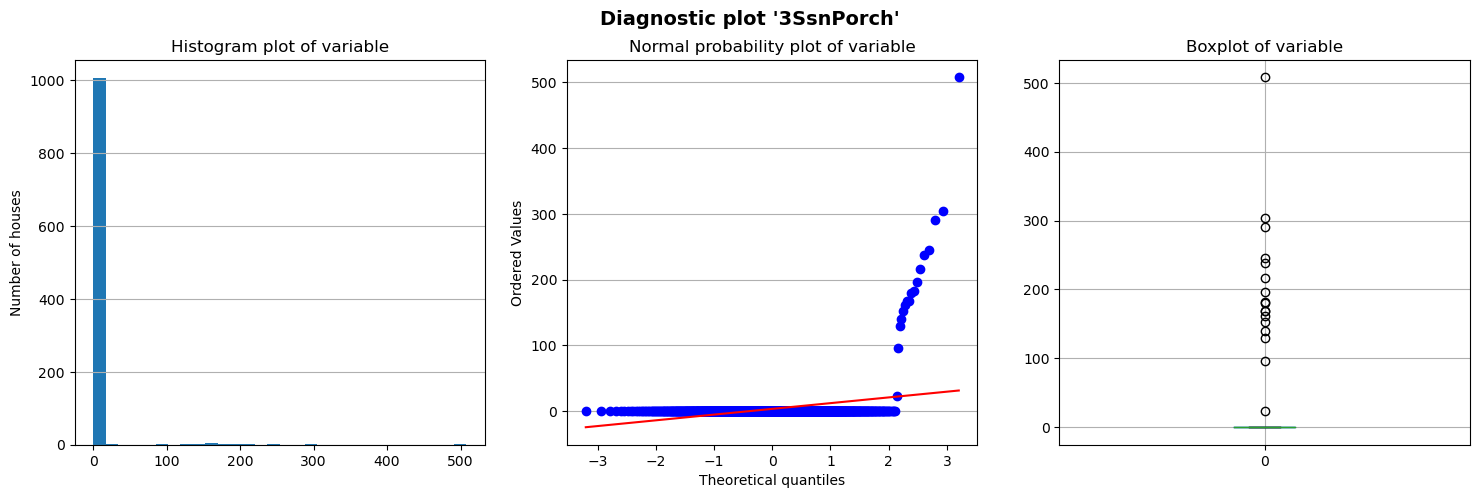

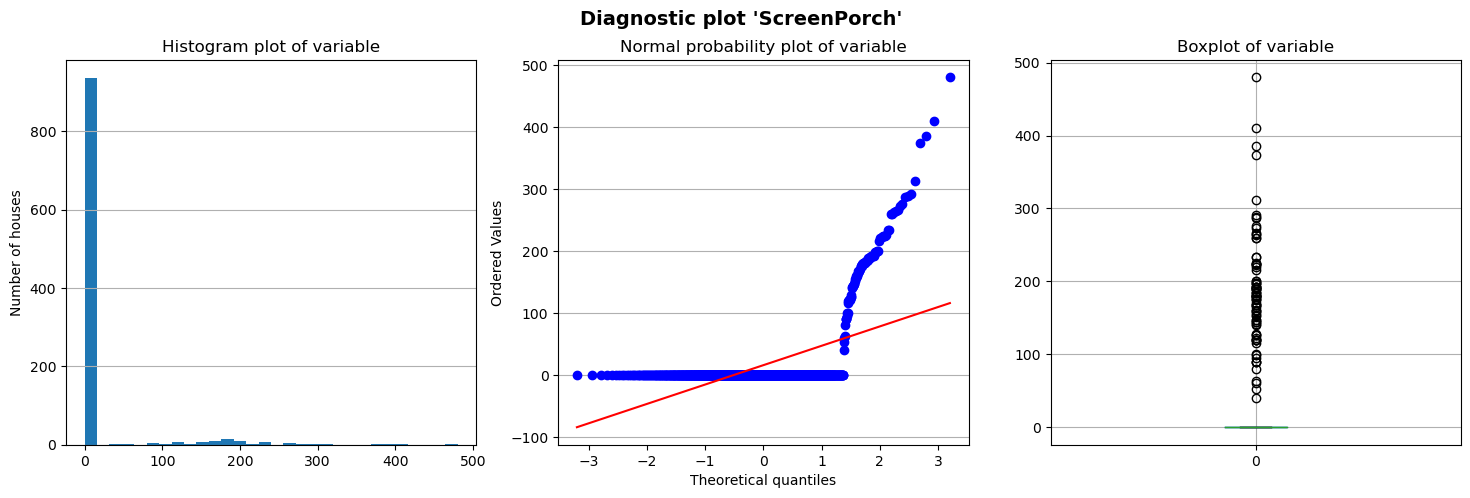

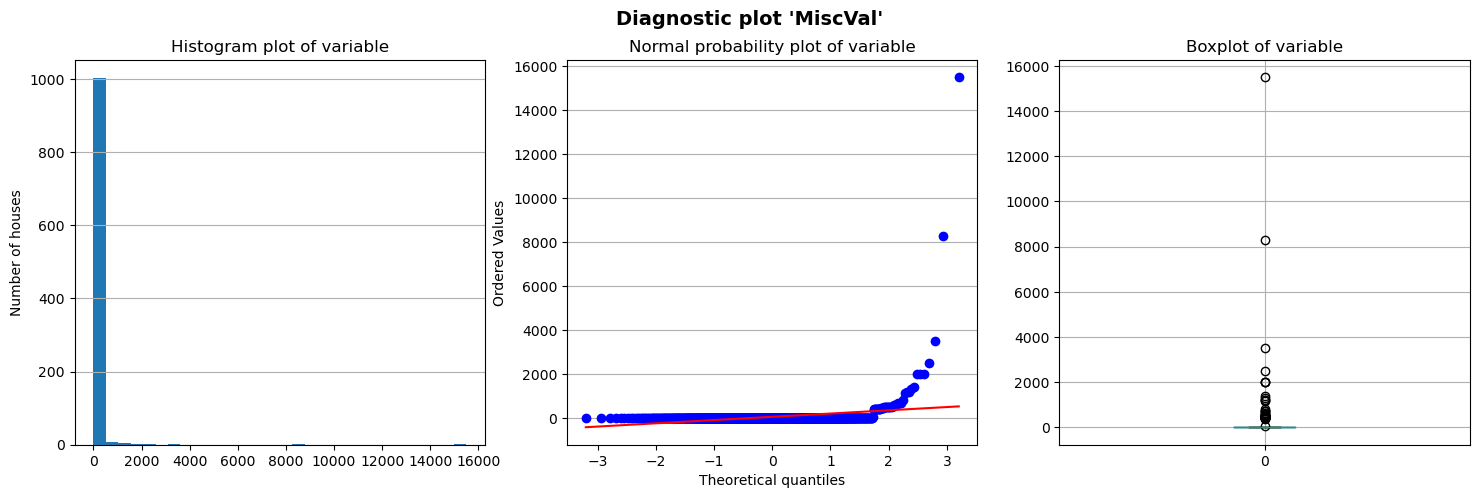

In [90]:
for var in numeric_vars[:20]:
    diagnostic_plots(X_train[numeric_vars], var)

- <b>Distribution plots explanation</b>
1. Distribution plots, also known as histograms, are used to visualize the distribution of a single continuous variable. They show the frequency of observationswithin a certain range of values, also known as bins. The height ofthe bars represents the number of observations within each bin, and the width of the bars represents the range of values that the bin covers.
2. The plot helps to understand the distribution of the variable, for example, if it is symmetric or skewed, if it has outliers, if it follows a normal distribution or not, what is the central tendency, and the spread of the variable.
3. There are different types of distribution plots such as histograms,density plots, violin plots, box plots and rug plots that can be used to visualize the distribution of a variable.

## Relationships with target value (correlation matrix)

A correlation matrix is a table showing correlation coefficients between a set of variables. Each cell in the table shows the correlation between two variables. Correlation matrices are used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses.

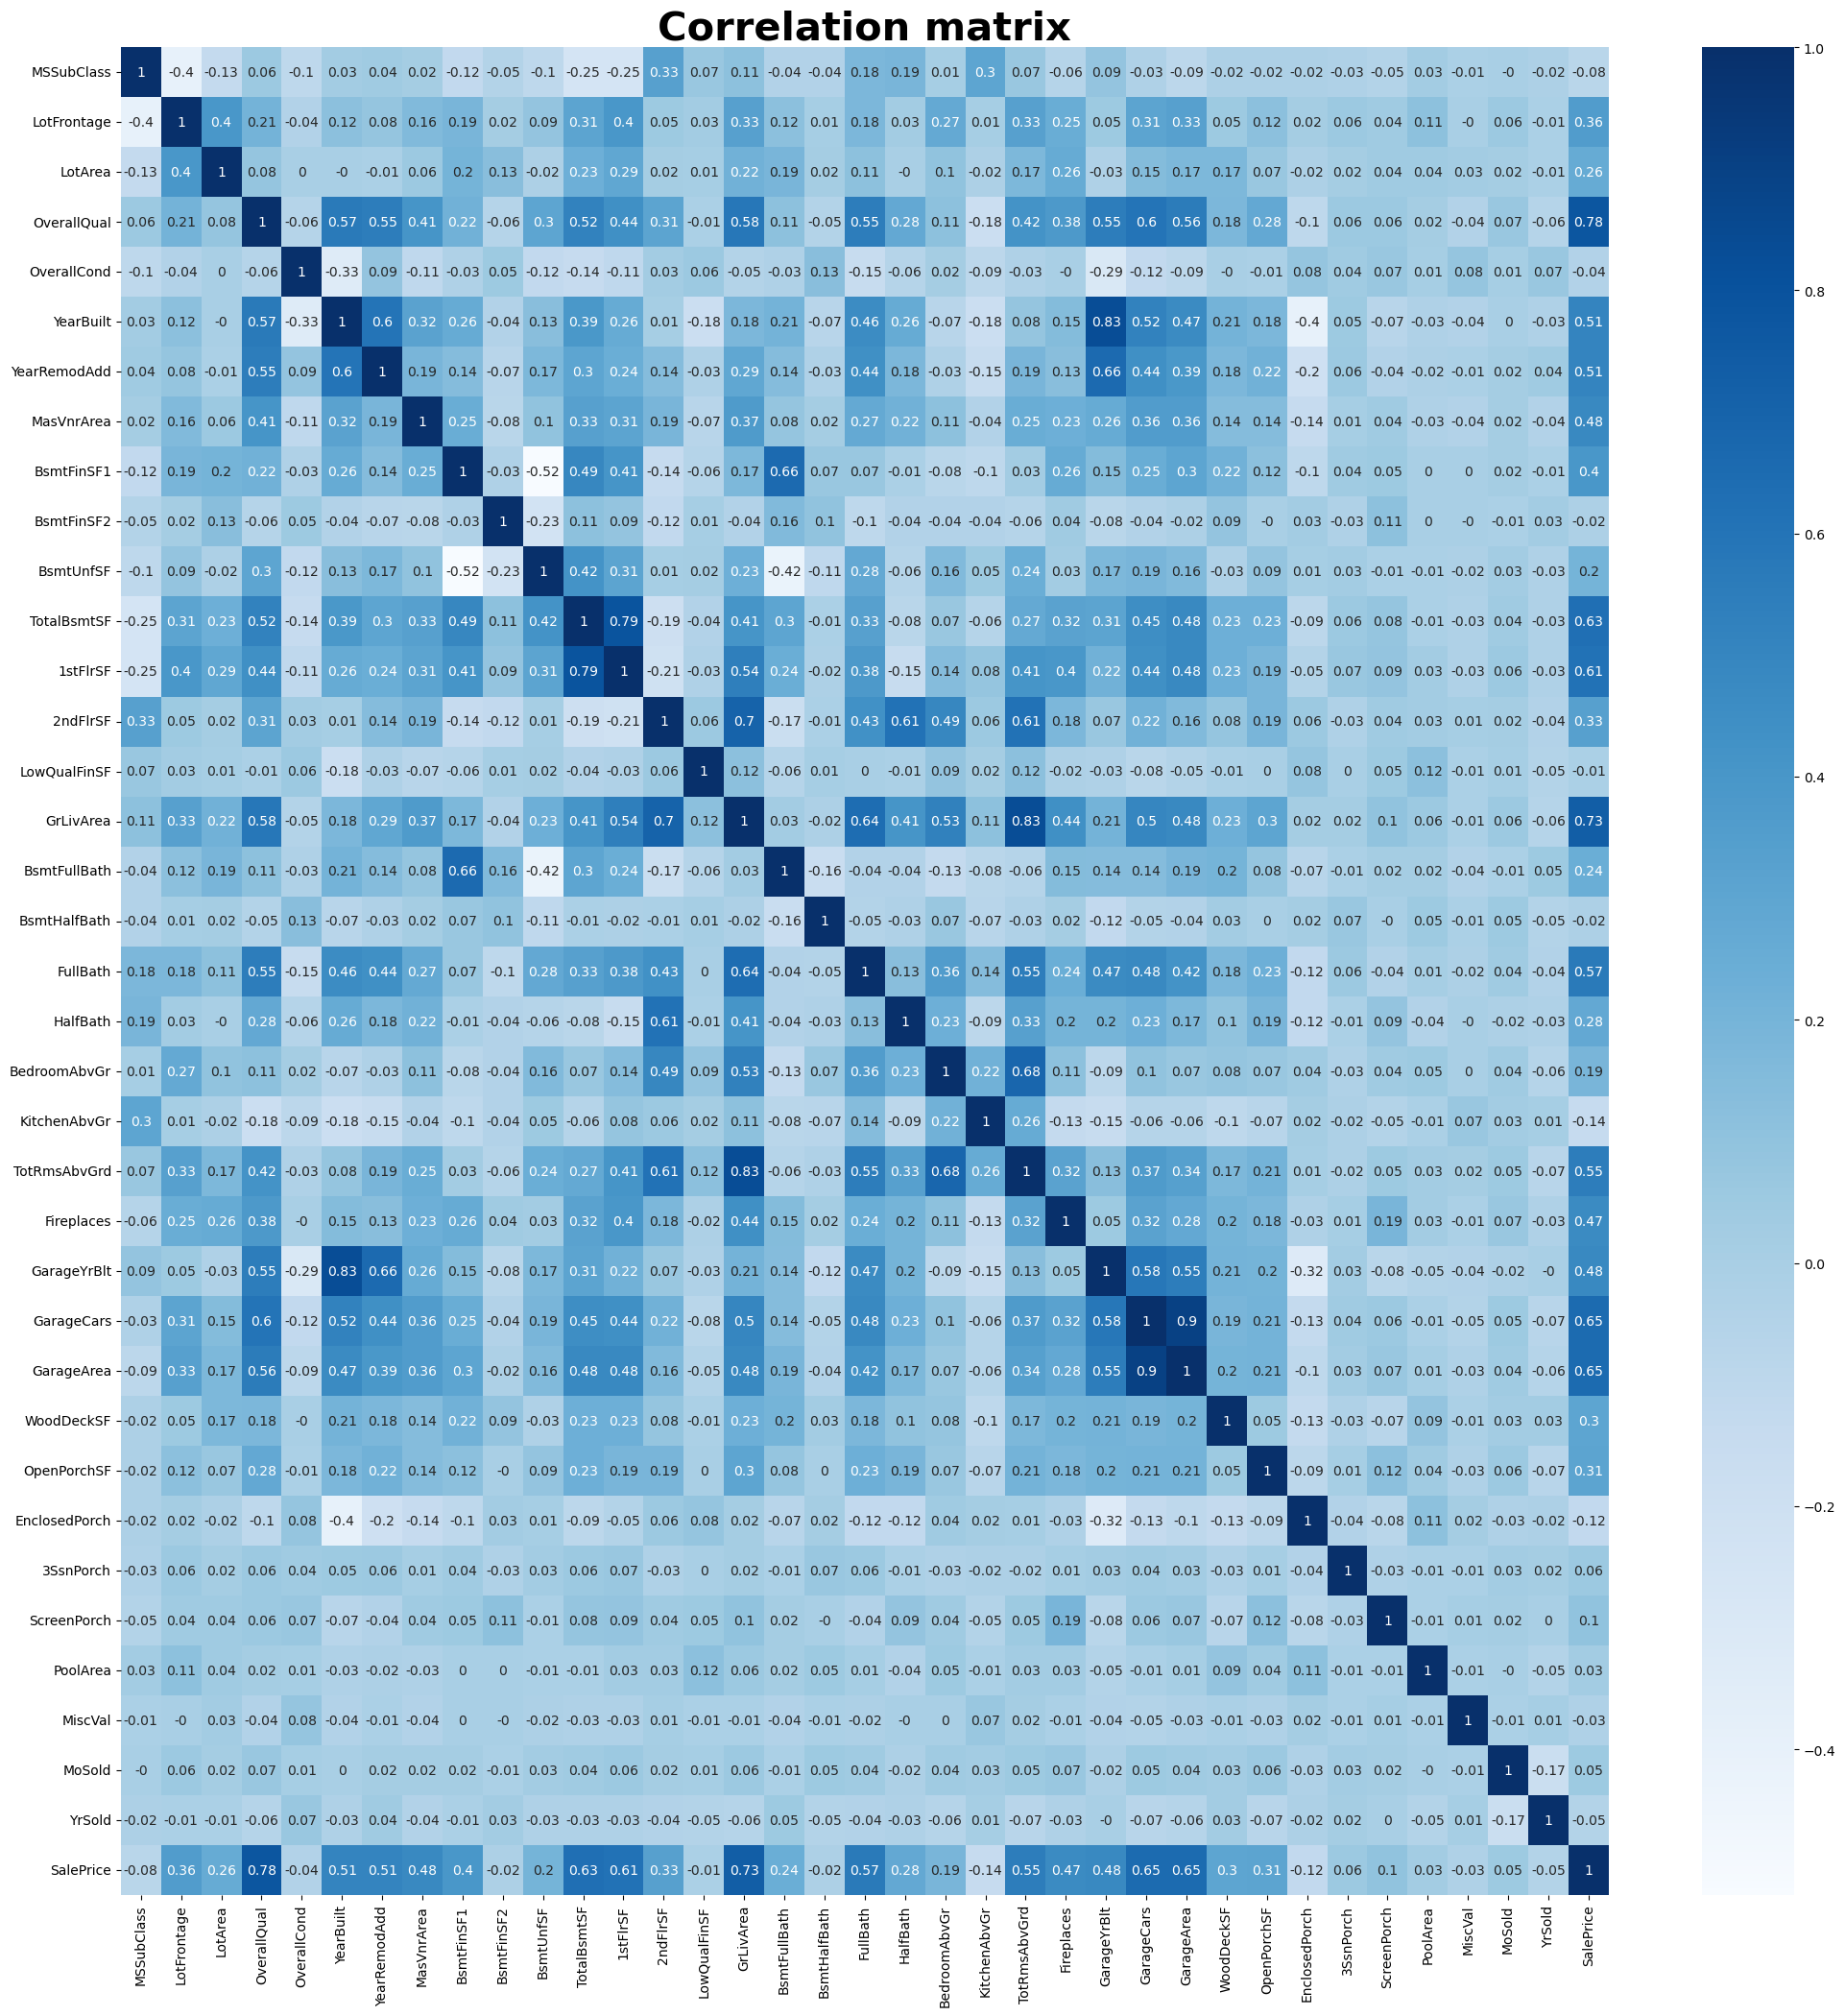

In [91]:
corr = pd.concat([X_train, y_train], axis =1).corr().round(2)
fig = plt.figure(figsize=(25, 25))

sns.heatmap(corr, annot = True, cmap="Blues")
plt.title('Correlation matrix',fontsize = 30,fontweight='bold')
plt.show()

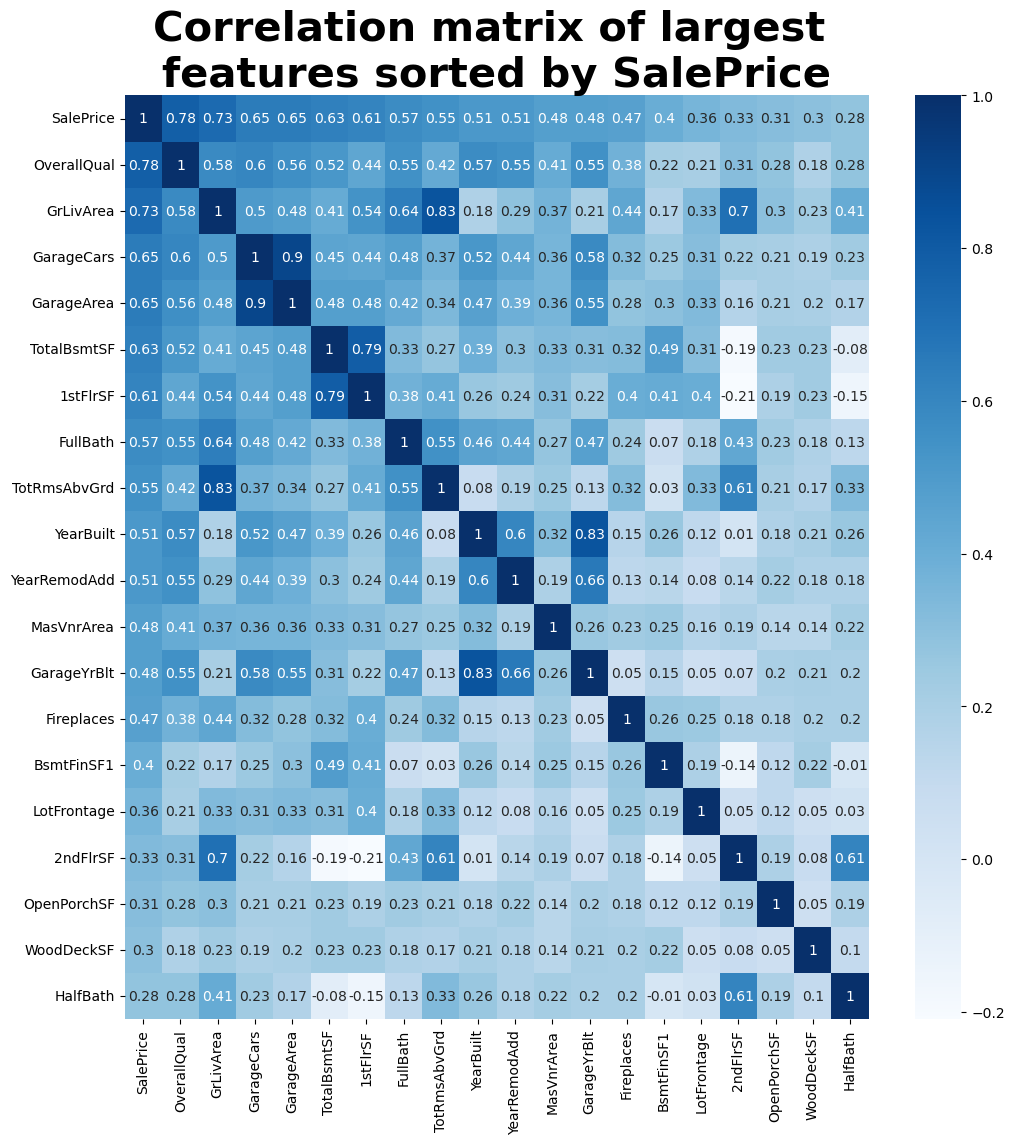

In [92]:
corr = pd.concat([X_train, y_train], axis =1).corr().round(2)
corr = corr.nlargest(20, 'SalePrice')

plt.figure(figsize = (12, 12))
sns.heatmap(corr[corr.index], annot = True, cmap = "Blues")
plt.title('Correlation matrix of largest \nfeatures sorted by SalePrice',fontsize = 30,fontweight='bold')
plt.show()

- Correlation heatmap shows that highly positively correlated between independent features 
    - (GarageCars, GarageArea - 0.9), 
    - (GrLiveArea, TotRmsAbvGrd - 0.83), 
    - (TotalBsmtSF, 1stFlrSF - 0.79), 
    - (YearBuilt, GarageYrBlt – 0.83)
<br><br>
- Correlation heatmap also shows that features 
    - (OveallQual, SalePrice - 0.78), 
    - (GrLiveArea, SalePrice - 0.73), 
    - (GarageCars, SalePrice - 0.65),
    - (GarageArea, SalePrice - 0.65),
    - (TotalBsmtSF, SalePrice - 0.63) 
    - (1stFlrSF, SalePrice - 0.61) 
    - are positively correleted with SalePrice 

--------------------
MSZoning
--------------------


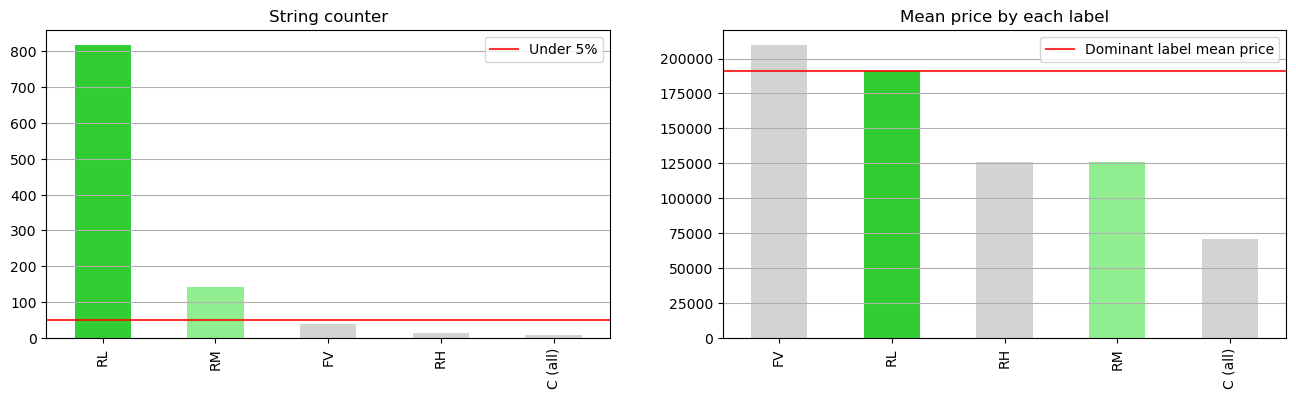

--------------------
Street
--------------------


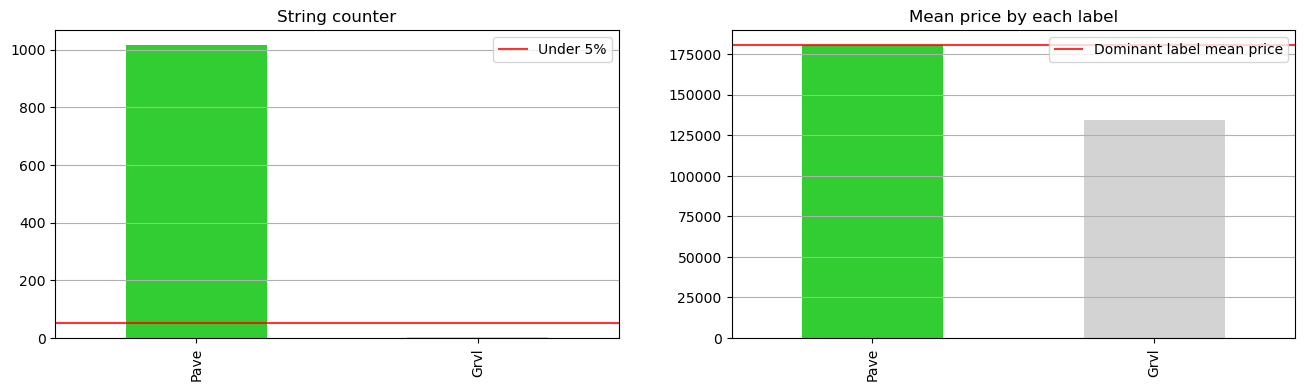

--------------------
LandContour
--------------------


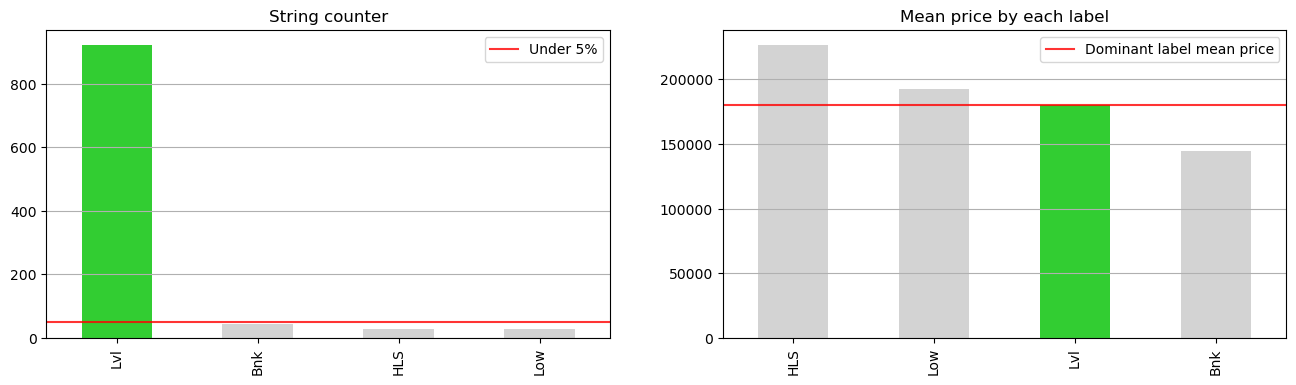

--------------------
Utilities
--------------------


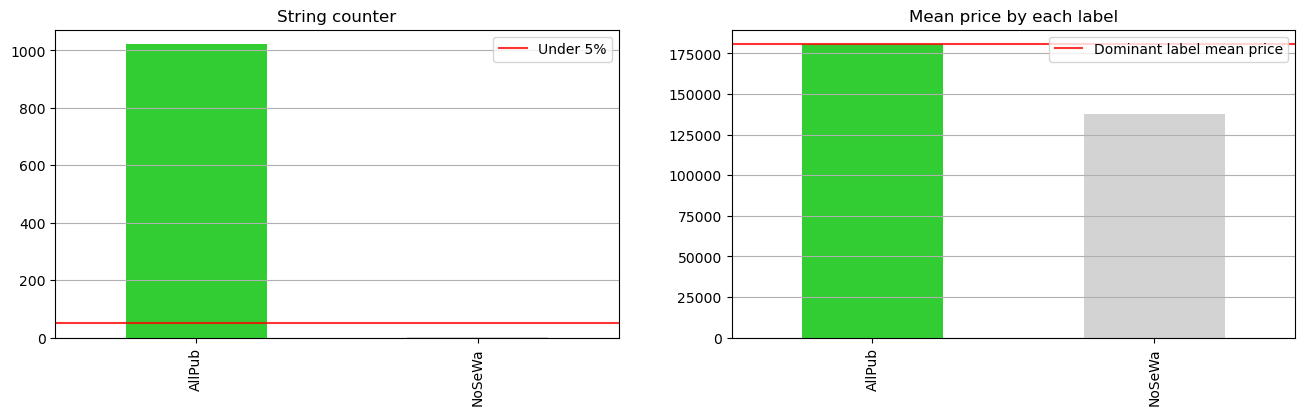

--------------------
LandSlope
--------------------


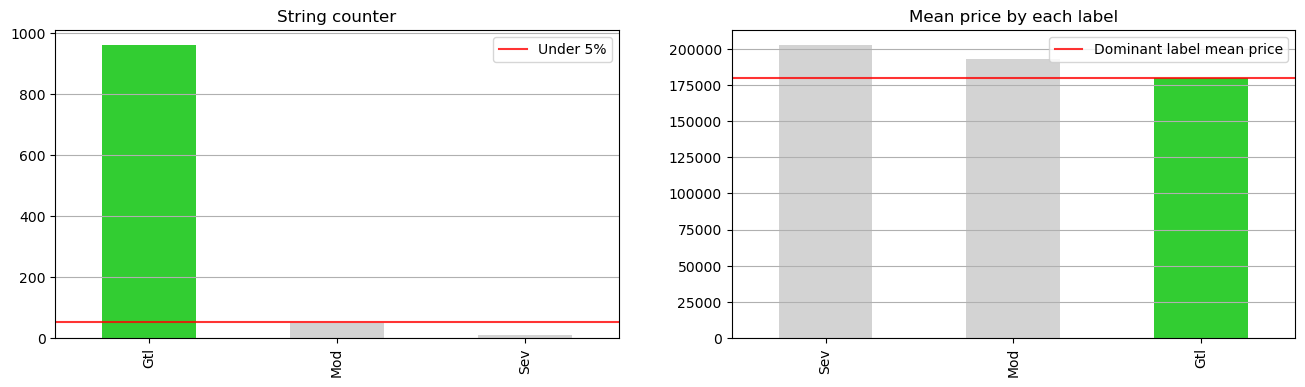

--------------------
Condition1
--------------------


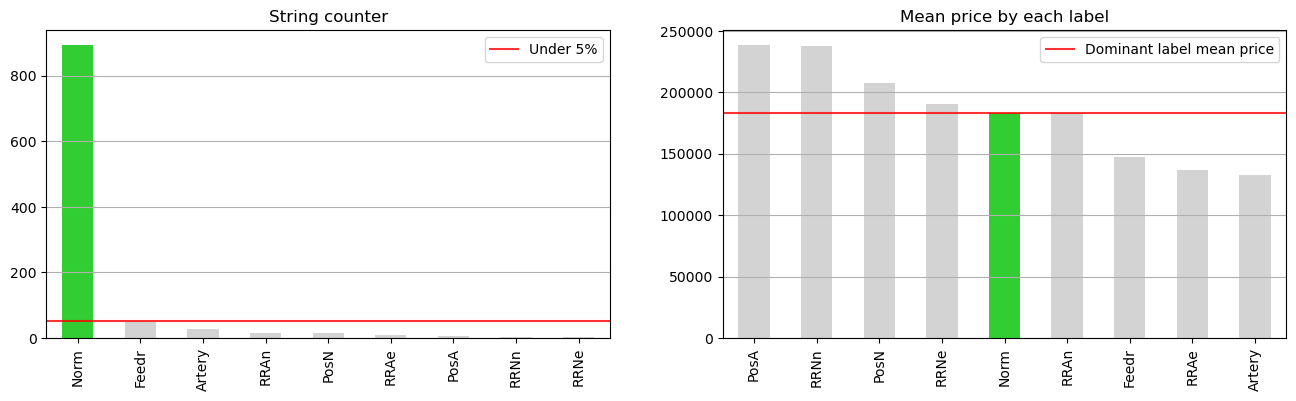

--------------------
Condition2
--------------------


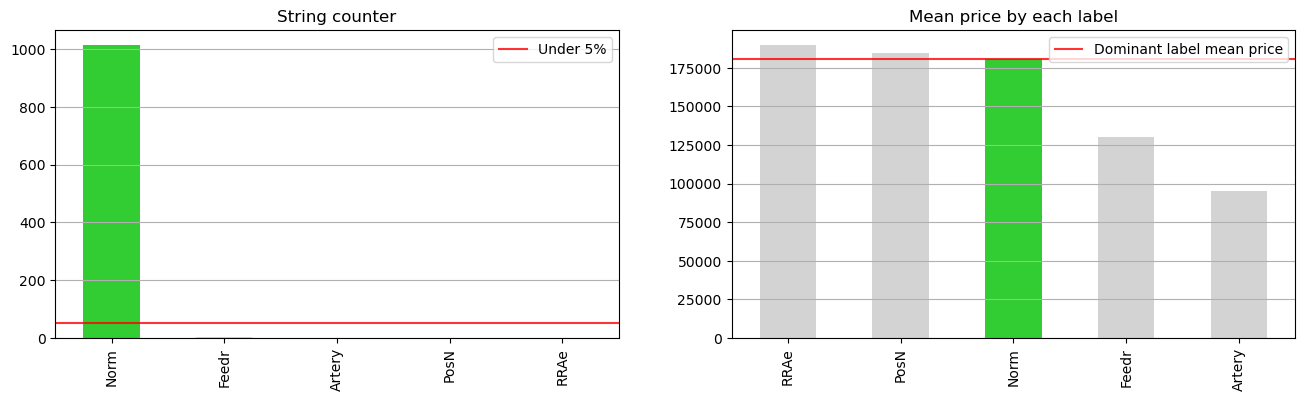

--------------------
BldgType
--------------------


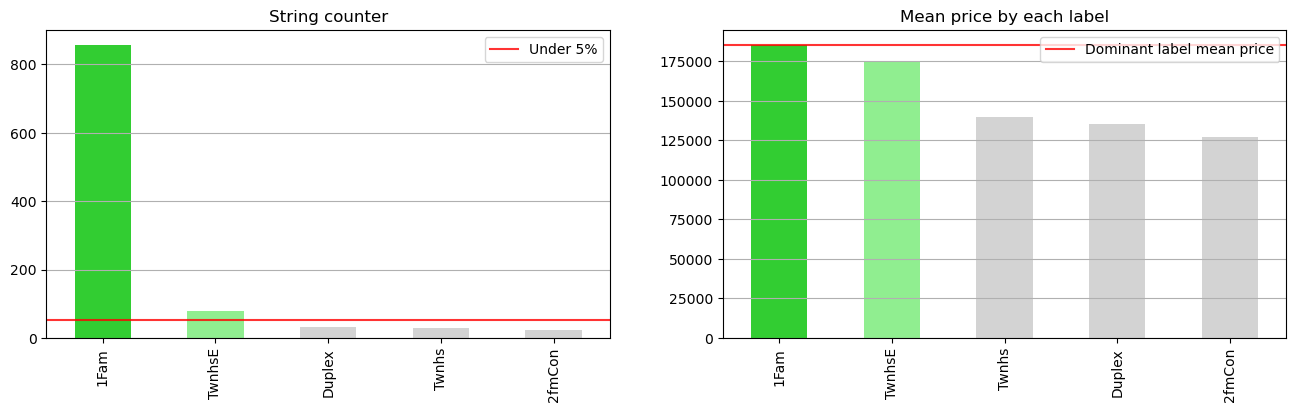

--------------------
RoofMatl
--------------------


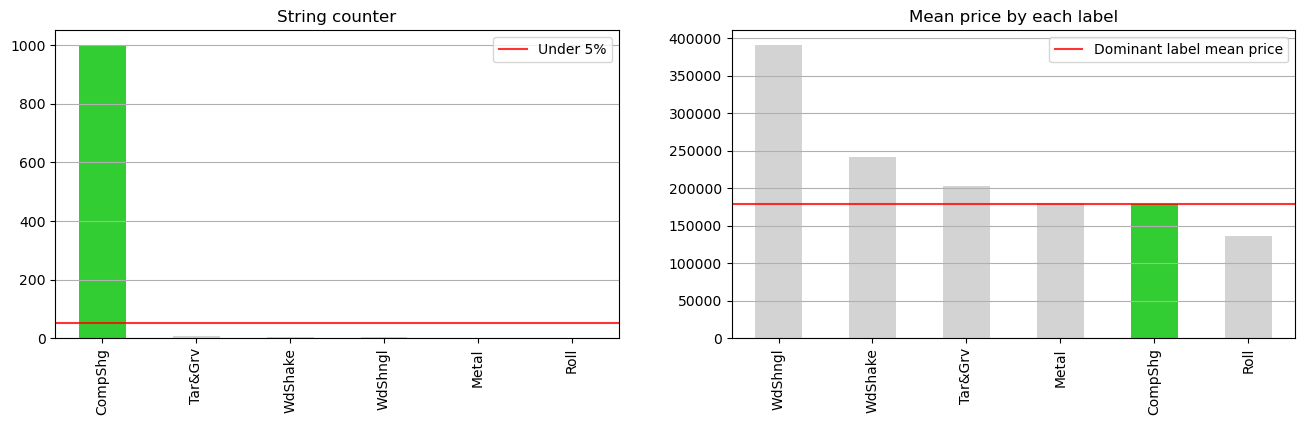

--------------------
ExterCond
--------------------


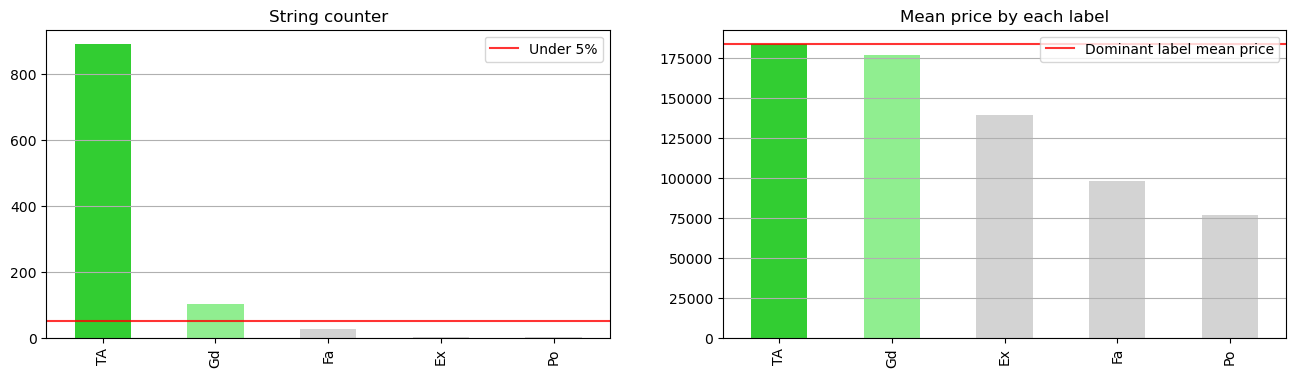

--------------------
BsmtCond
--------------------


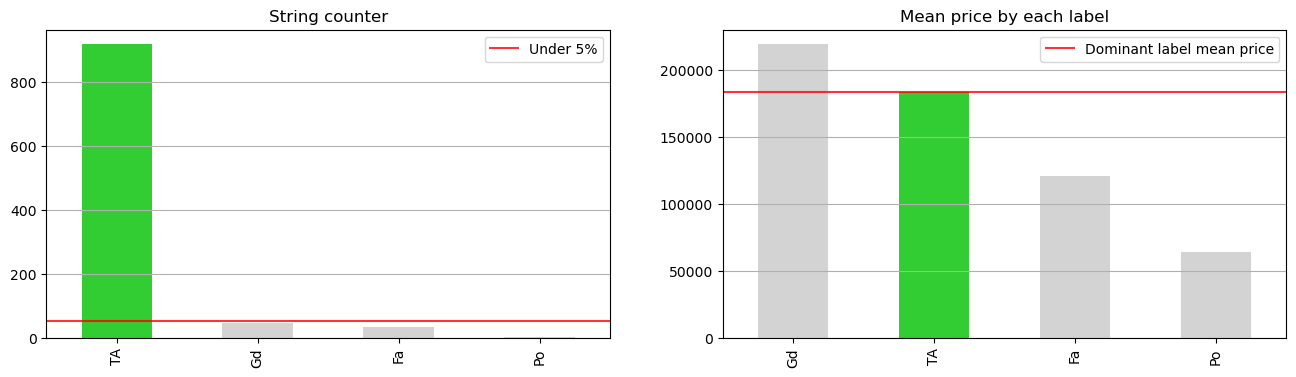

--------------------
BsmtFinType2
--------------------


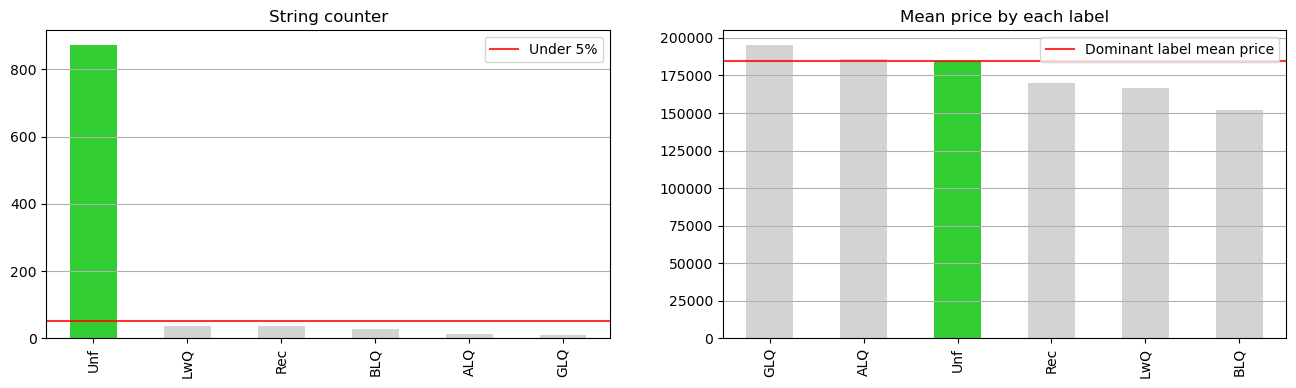

--------------------
Heating
--------------------


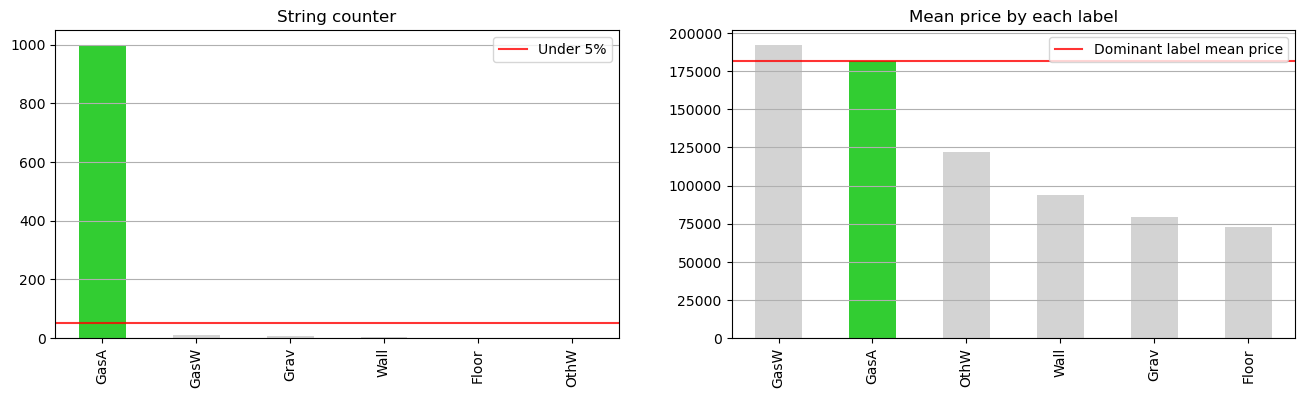

--------------------
CentralAir
--------------------


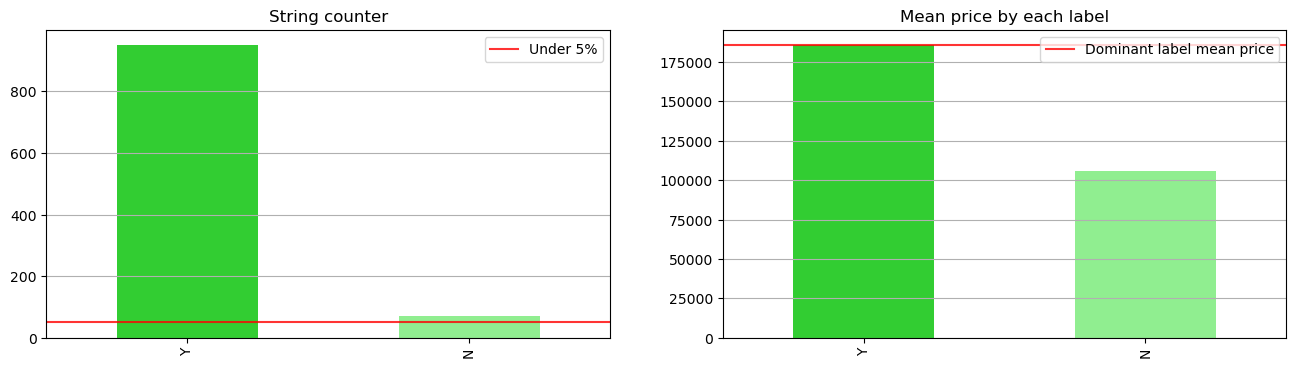

--------------------
Electrical
--------------------


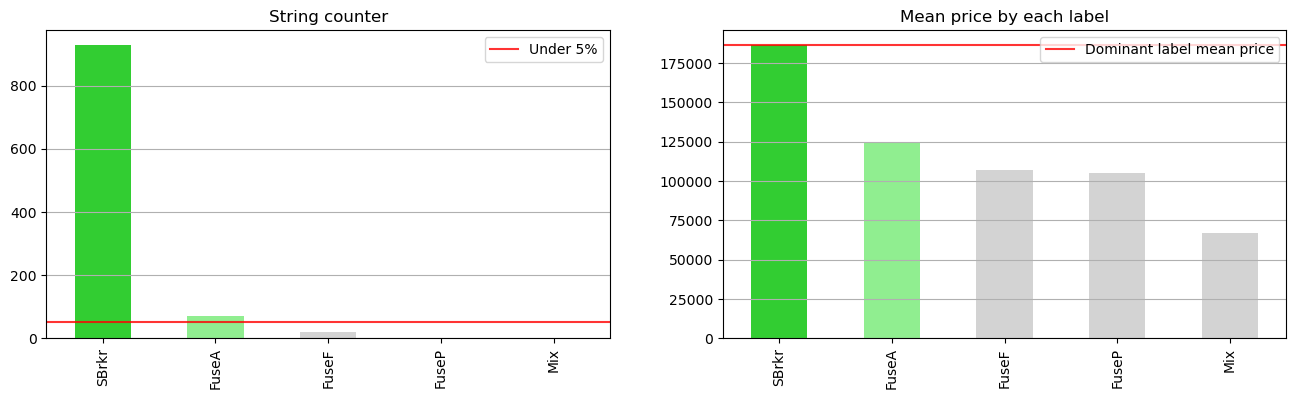

--------------------
Functional
--------------------


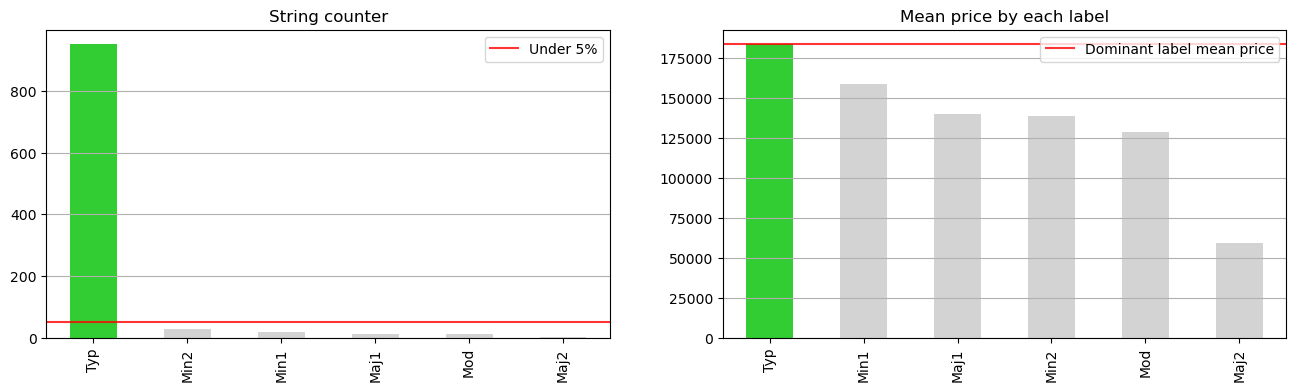

--------------------
GarageQual
--------------------


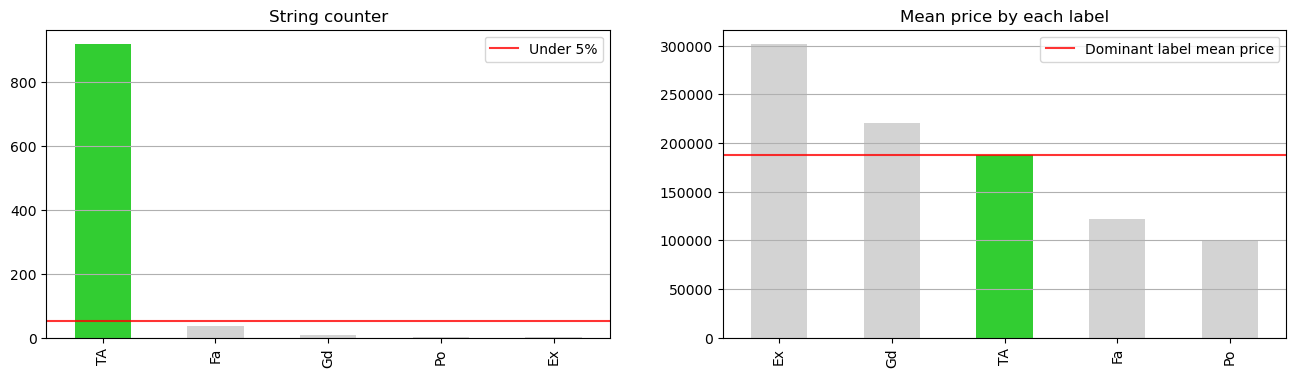

--------------------
GarageCond
--------------------


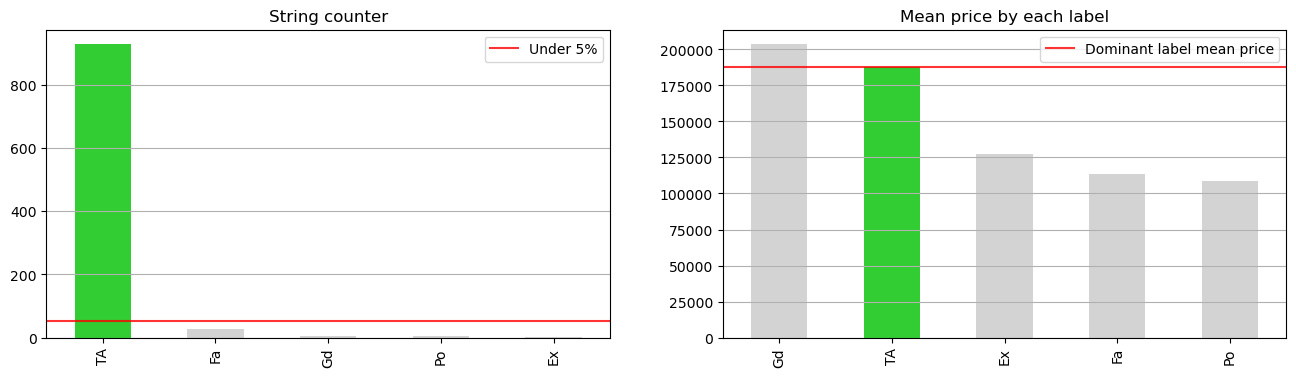

--------------------
PavedDrive
--------------------


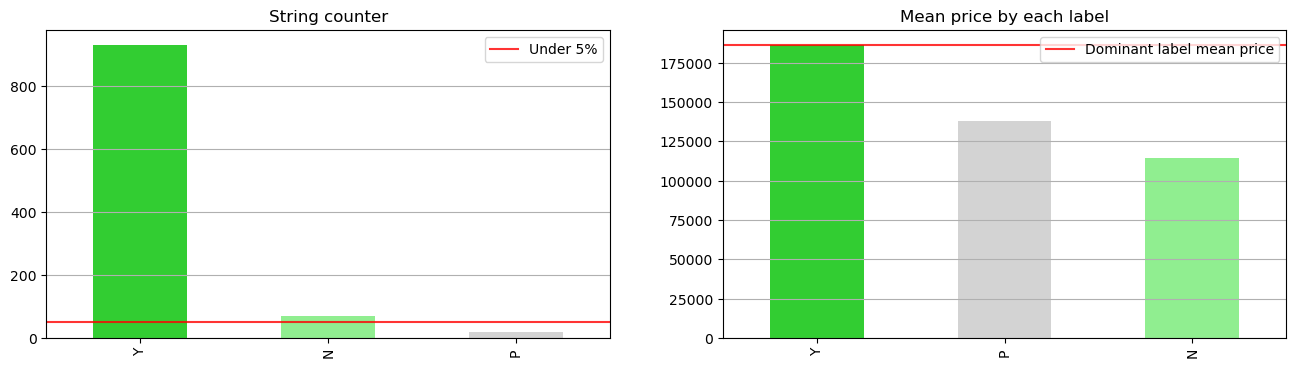

--------------------
SaleType
--------------------


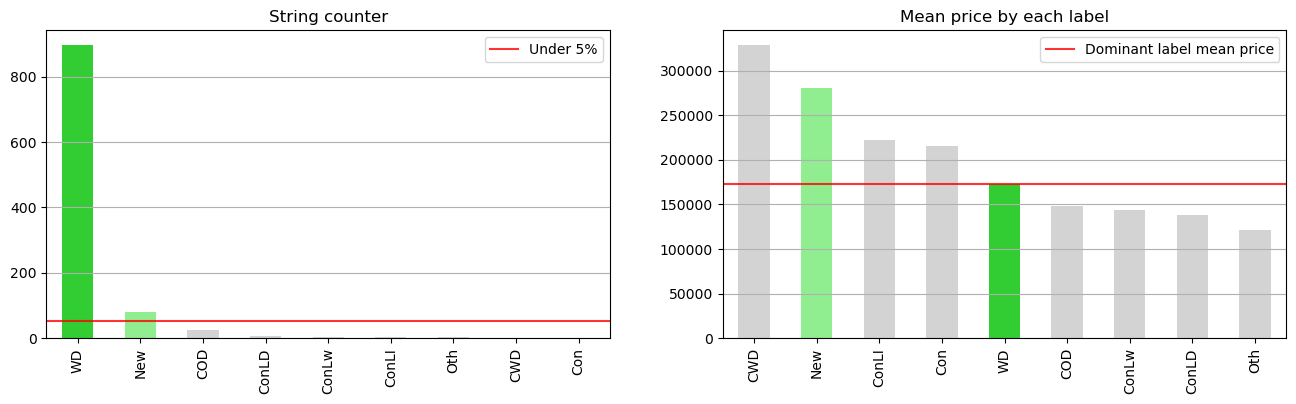

In [93]:
# Dominant categories observation
for col in dominant_cat_analyser(X_train, y_train, 'hard', 'no')[:20]:
    categorical_var_analyser(X_train,y_train,col)

- <b>Conclusion</b>
    - The diagrams depict the presence of dominant labels within the variables. The left plot displays<br> the distribution of data, while the right plot illustrates the average price in relation to each label.

## Feature engineering

In [94]:
# Defind useless columns by multicollinearity and missing indicator.
multicollinearity_list = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt']

# Defind weak correlation features
correlation_drop_list = correlation_filter(X_train,y_train, 0.2)

# Defind dominant features
dominant_features_list = dominant_cat_analyser(X_train, y_train, 'hard', 'no')

# Dropping defined columns
print('Train')
X_train = drop_useless_col(X_train,dominant_features_list + correlation_drop_list + multicollinearity_list)
print('Test')
X_test = drop_useless_col(X_test,dominant_features_list + correlation_drop_list + multicollinearity_list)

Train
Dropped :  ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'KitchenAbvGr', 'MSSubClass', 'GarageArea', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt']
Test
Dropped :  ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'OverallCond', 'BsmtFinSF2', 'LowQual

## Imputation section

In [95]:
# Features containing NaN values and their data types
info_df = pd.concat([
    X_train[X_train.columns].isnull().mean().sort_values(ascending=False)[:4],
    X_train[X_train[X_train.columns].isnull().mean().sort_values(ascending=False)[:4].index].dtypes
],axis=1)
info_df.columns = ['NaN mean','Dtype']
info_df

NaN mean    Dtype
LotFrontage   0.184932  float64
GarageFinish  0.052838   object
GarageType    0.052838   object
BsmtQual      0.023483   object

## Imputation numerical features

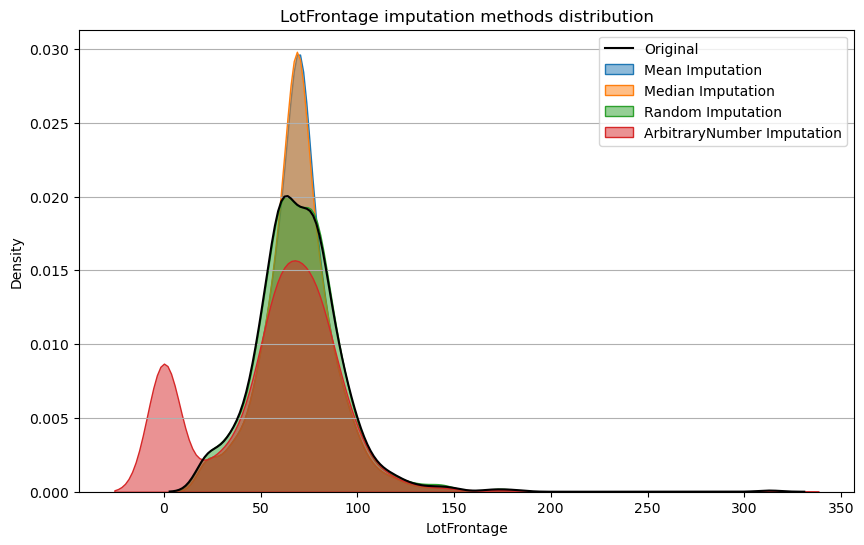

In [96]:
# MeanMedian, RandomSample imputation observation

# Create df with target feature
analysis_df = pd.concat([
    X_train['LotFrontage'].copy(),
    X_train['LotFrontage'].copy(),
    X_train['LotFrontage'].copy(),
    X_train['LotFrontage'].copy(),
    X_train['LotFrontage'].copy()
],axis=1)
analysis_df.columns = [
    'LotFrontage','LotFrontage_mean','LotFrontage_median','LotFrontage_random','LotFrontage_arbitrary'
]
analysis_df

# Imputation pipe by methods
imputer_pipe = Pipeline([
    ('mean',MeanMedianImputer(imputation_method='mean',variables=['LotFrontage_mean'])),
    ('median',MeanMedianImputer(imputation_method='median',variables=['LotFrontage_median'])),
    ('random',RandomSampleImputer(variables=['LotFrontage_random'])),
    ('arbitrary',ArbitraryNumberImputer(arbitrary_number=0,variables=['LotFrontage_arbitrary']))
])

analysis_df = imputer_pipe.fit_transform(analysis_df)

# Create the KDE plot
plt.figure(figsize=(10,6))
sns.kdeplot(analysis_df['LotFrontage'].dropna(), label='Original', shade=False, color = 'black')
sns.kdeplot(analysis_df['LotFrontage_mean'], label='Mean Imputation', shade=True, alpha=0.5)
sns.kdeplot(analysis_df['LotFrontage_median'], label='Median Imputation', shade=True, alpha=0.5)
sns.kdeplot(analysis_df['LotFrontage_random'], label='Random Imputation', shade=True, alpha=0.5)
sns.kdeplot(analysis_df['LotFrontage_arbitrary'], label='ArbitraryNumber Imputation', shade=True, alpha=0.5)

# Add the legend
plt.legend()

# Add grid
plt.grid(axis='y')

# Title 
plt.title('LotFrontage imputation methods distribution')

# Show the plot
plt.show()


In [97]:
print('Original variance: ', analysis_df['LotFrontage'].var())
print('Variance after mean imputation: ', analysis_df["LotFrontage_mean"].var())
print('Variance after median imputation: ', analysis_df["LotFrontage_median"].var())
print('Variance after random imputation: ', analysis_df["LotFrontage_random"].var())
print('Variance after arbitrary imputation: ', analysis_df["LotFrontage_arbitrary"].var())

Original variance:  532.5872021885676
Variance after mean imputation:  433.9985819989113
Variance after median imputation:  434.06604265416564
Variance after random imputation:  531.4193291178781
Variance after arbitrary imputation:  1166.3258000770516


- <b>Conclusion </b>
    - This plot illustrates the variations in data distribution of a variable, depending on the <br>imputation method applied.The Mean-Median imputer is found to be the best<br> as it does not significantly change the original distribution<br> of the data when compared to other methods.

### Compare correlation after mean, median, random sample and arbitrary imputation

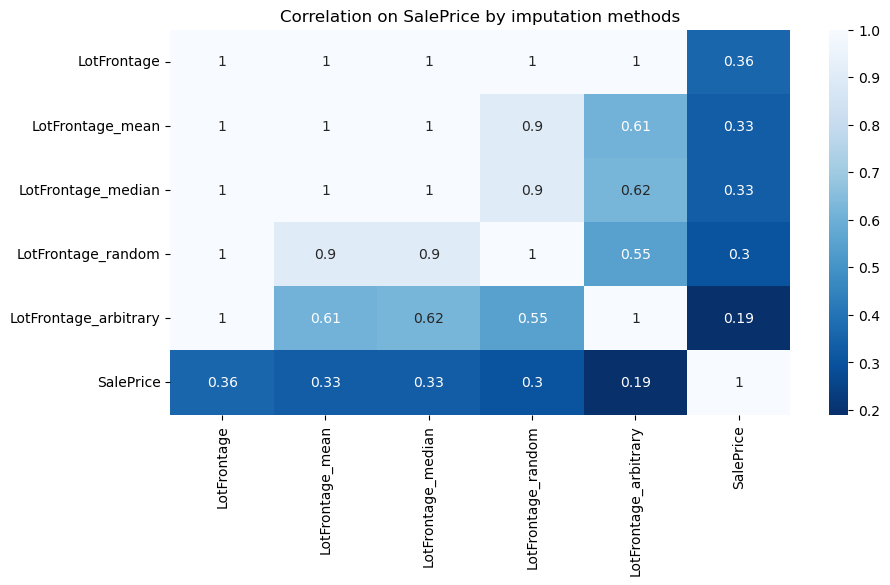

In [98]:
fig = plt.figure(figsize=(10, 5))
sns.heatmap(pd.concat([analysis_df,y_train],axis=1).corr().round(2), annot = True, cmap="Blues_r")
plt.title('Correlation on SalePrice by imputation methods')
plt.show()

- <b>Conclusion</b>
    1. The correlation matrix shows how much the relationship between a variable and the chosenmethod of imputing missing values varies.
    2. The best results are seen when utilizing themean and median replacement methods, as per the data from the matrix.

## Imputation categories features

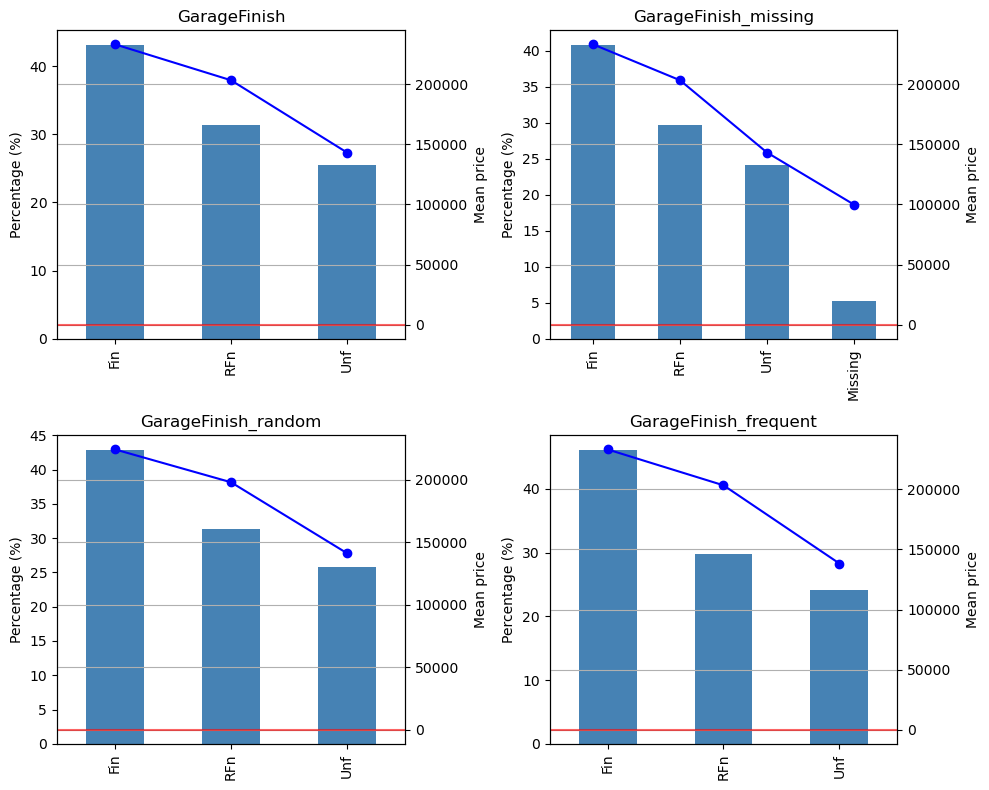

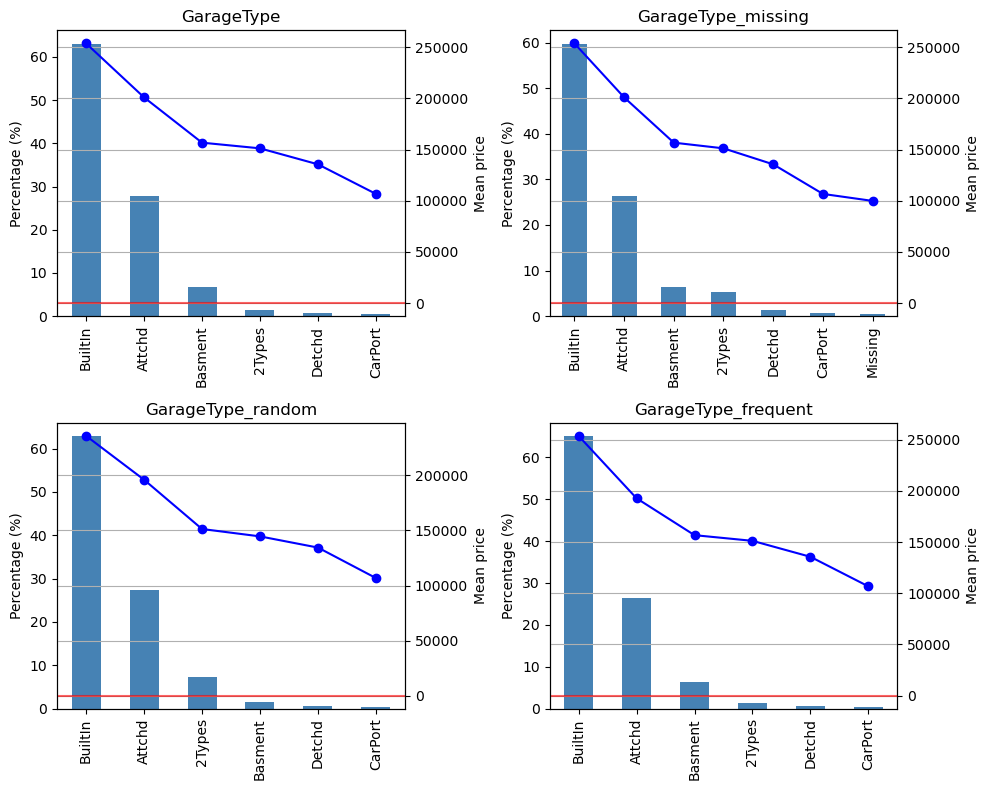

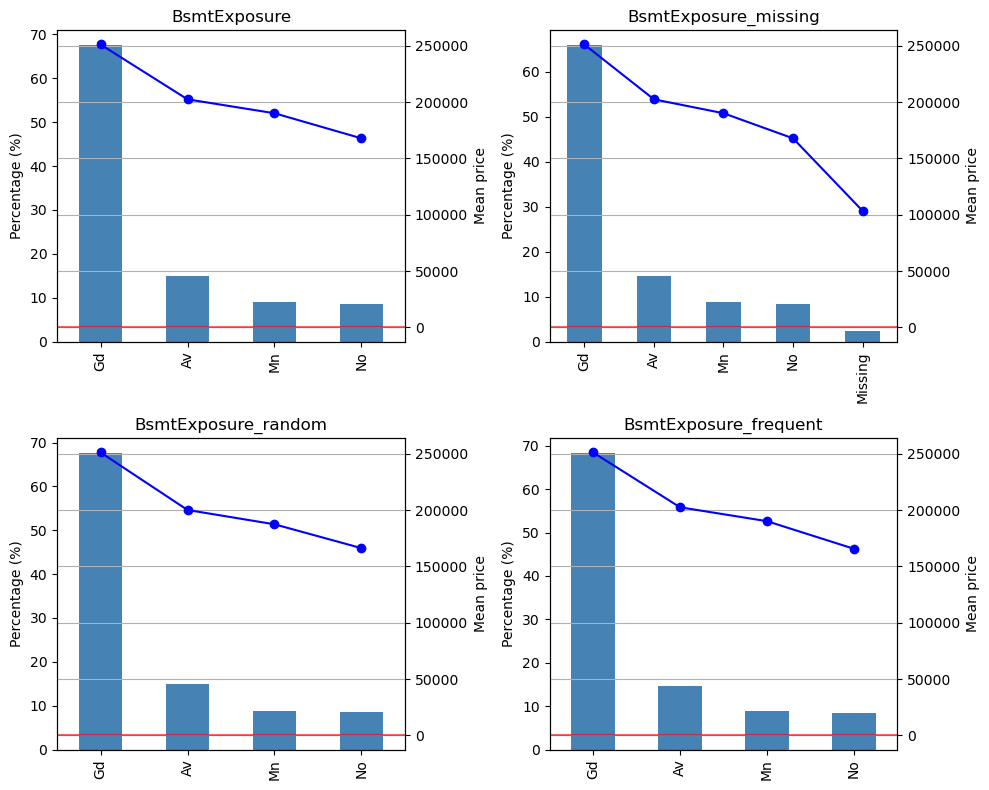

In [102]:
cat_nul_list = [
    'GarageFinish',
    'GarageType',
    'BsmtExposure'
]

# iterate through each column in the list of categorical columns
for col in cat_nul_list:
    # create a 4-panel figure using the plt.subplots() function
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    i = 1
    # iterate through different imputation methods
    for name in [col,col+'_missing',col+'_random',col+'_frequent']:
        plt.subplot(2, 2, i)
        analysis_df[col] = X_train[col].copy()
        analysis_df[col+'_missing'] = CategoricalImputer().fit_transform(X_train[[col]])
        analysis_df[col+'_random'] = RandomSampleImputer().fit_transform(X_train[[col]])
        analysis_df[col+'_frequent'] = CategoricalImputer(imputation_method='frequent').fit_transform(X_train[[col]])
        plot_categories(analysis_df, y_train, name)
        i += 1
    # adjust the layout of the figure
    plt.tight_layout()
    # show the plot
    plt.show()

- <b>Conclusion</b>
    - In addition, we have made some observations on how the price and data distribution in <br>variables with missing values in their categories have changed.

## Discretization datetime features

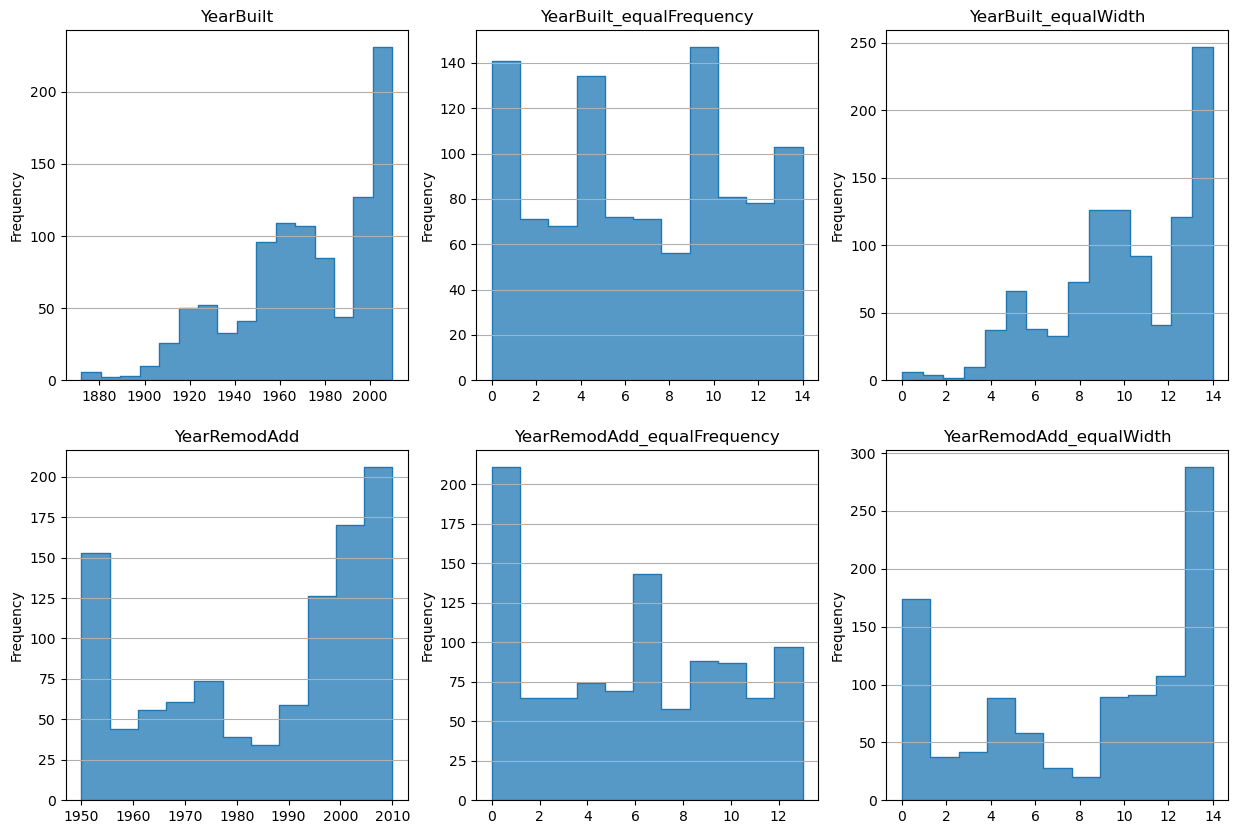

In [100]:
# initialize list of columns to be discretized
year_list = ['YearBuilt', 'YearRemodAdd']

# initialize equal frequency discretization object
equalFrequency = EqualFrequencyDiscretiser(
    q = 15, # number of quantiles to create
    variables = year_list, # columns to be discretized
    return_object = True # return an object that can be used to transform new data
)

# initialize equal width discretization object
equalWidth = EqualWidthDiscretiser(
    bins = 15, # number of bins to create
    variables = year_list, # columns to be discretized
    return_object= True # return an object that can be used to transform new data
)

# fit the discretization objects to the training data
equalFrequency.fit(X_train)
equalWidth.fit(X_train)

# create a new dataframe to hold the discretized values
discretization_df = pd.DataFrame()

# create subplots with figsize
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
i = 1
# loop through the columns to be discretized
for col in year_list:
    discretization_df[col] = X_train[[col]].copy()
    discretization_df[col+'_equalFrequency'] = equalFrequency.transform(X_train)[[col]]
    discretization_df[col+'_equalWidth'] = equalWidth.transform(X_train)[[col]]
    for name in [col,col+'_equalFrequency',col+'_equalWidth']:
        # create a subplot for the current column
        plt.subplot(2,3,i)
        sns.histplot(
            data=discretization_df[col],
            x=discretization_df[name],
            element='step'
        )
        plt.xlabel('')
        plt.ylabel('Frequency')
        plt.title(name)
        # add grid to the subplot
        plt.grid(axis='y')
        # increment the subplot index
        i+=1
# display the plot
plt.show()

- <b>Conclusion</b>
    - In this visualization, we can observe the distribution of data after the application of discretization techniques.